Preciso separar em 10 e 20Nm pq se deixar os dois juntos os Limites de Controles ficam gigantes, e da um erro absurdo

# Imports

In [1]:
import pandas as pd 
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")

In [2]:
from funcoes_module import rms, pk_pk, kurtosis, crest_factor, skewness, shape_factor, std_value, min_value, max_value, mean_value

In [3]:
from funcoes_module import extract_info_from_filename, extract_and_format_dataframe, format_time, features_extract, features_timeframe,format_dataframe_basona ,extract_datasets_and_process_features,read_1file_datasets , combine_features_datasets 

In [4]:
from funcoes_module import plot_df,plot_df_features, compare_df_plots #,plot_health_non_health_features

In [5]:
from descricoes_SE import descricao_falha



# Ciclo 2

## Objetivos
1. Importar dados de treino e tratar coluna Fault
2. Correlacionar 40 features com a coluna Fault e filtrar as 10 de mais importâncias
   1. Usar Chi-test(categoric label)
3. Plotar gráficos das correlações features vs coluna
4. Criar regras do sistema baseado nas features filtradas
5. Plotar Confusion Matrix e métricas do SE
6. Plotar métricas de avaliação vs número de features
7. Avaliar desempenho Conjunto de Testes
8. Resultados

### RESPOSTAS
1. Entender porquê o gear-pitting ta dando um torque tão diferente dos demais, tá puxando 10Nm no de 20Nm??
* Tudo certo, é uma característica da falha mesmo, rola tanto com 10 ou Nm, vai ser fácil de diferenciar

## 1. Importar Dados de Treino e tratar coluna Fault

In [6]:
#upando base de dados
df_features_org = combine_features_datasets("todos","inicial",0.1) #treino,teste,todos ; inicial,final ; timeframe
#avaliar problema gearpitting, remover ele é bom no momento para a visualização dos gráficos
#df_features_org = df_features_org[df_features_org['Fault']!='gear_pitting']
df_features_org_teste = combine_features_datasets("todos","final",0.1)

Columns [col] not found in [filename]
number of files geral = 23
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_M_to

### Funções Formatação

In [7]:
#### #### Funções Formatação #### ####
def normalize_data(dataframe):
    scaler = MinMaxScaler() 
    # Selecting numerical columns in the DataFrame
    numerical_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    #normalized_df =dataframe.copy()
    # Fitting the scaler and transforming the data
    dataframe[numerical_cols] = scaler.fit_transform(dataframe[numerical_cols])
    return dataframe
normalized_dataframe = normalize_data(df_features_org)

In [8]:
# Define your features (X) and target (y)
X = normalized_dataframe.select_dtypes(include=['int64', 'float64'])
y = normalized_dataframe['Fault']

# Calculate the mutual information for each feature
mi_scores = mutual_info_classif(X, y)

# Create a DataFrame to hold the results
mi_results = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})

# Sort by MI Score
mi_results = mi_results.sort_values(by='MI Score', ascending=False)

# Display the results
mi_results

,Feature,MI Score
6,Input Torque.mean,1.390160
8,Input Torque.min,1.253436
0,Input Torque.rms,1.187170
9,Input Torque.max,1.077771
30,gearbox_vibration_z.rms,0.653408
37,gearbox_vibration_z.std,0.651063
20,gearbox_vibration_y.rms,0.647049
27,gearbox_vibration_y.std,0.645754
14,gearbox_vibration_x.skewness,0.641592
10,gearbox_vibration_x.rms,0.634883


In [9]:
top_features1 = mi_results.nlargest(10,'MI Score')['Feature'].tolist()

In [10]:
mi_results

,Feature,MI Score
6,Input Torque.mean,1.390160
8,Input Torque.min,1.253436
0,Input Torque.rms,1.187170
9,Input Torque.max,1.077771
30,gearbox_vibration_z.rms,0.653408
37,gearbox_vibration_z.std,0.651063
20,gearbox_vibration_y.rms,0.647049
27,gearbox_vibration_y.std,0.645754
14,gearbox_vibration_x.skewness,0.641592
10,gearbox_vibration_x.rms,0.634883


## Checando se há correlação reduntante entre as variáveis

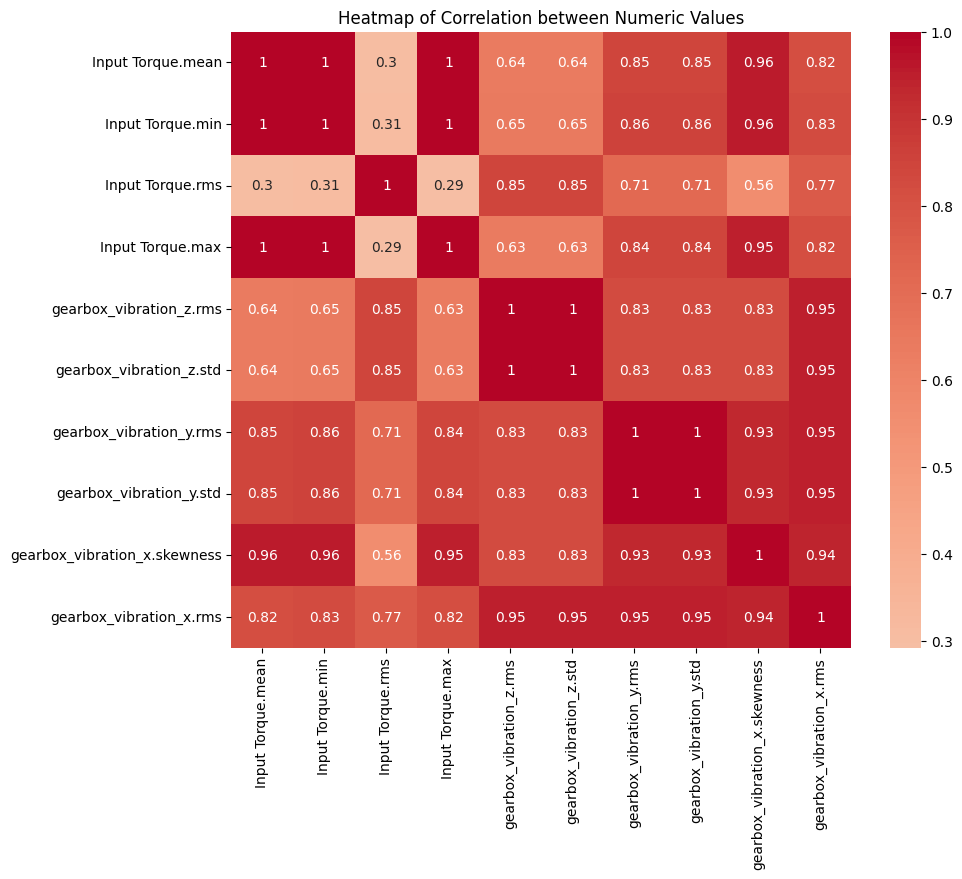

In [11]:
df_x = df_features_org[top_features1].corr()
correlation_matrix = abs(df_x.corr())

# Plotar o mapa de calor da correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlation between Numeric Values')
plt.show()

In [12]:
# Define the threshold for dropping highly correlated features
correlation_threshold = 0.8

# Sort the features by MI Score
sorted_features = mi_results.sort_values(by='MI Score', ascending=False)['Feature']

# Calculate the correlation matrix
correlation_matrix = X[sorted_features].corr()
correlation_matrix
sorted_features

6                    Input Torque.mean
8                     Input Torque.min
0                     Input Torque.rms
9                     Input Torque.max
30             gearbox_vibration_z.rms
37             gearbox_vibration_z.std
20             gearbox_vibration_y.rms
27             gearbox_vibration_y.std
14        gearbox_vibration_x.skewness
10             gearbox_vibration_x.rms
17             gearbox_vibration_x.std
24        gearbox_vibration_y.skewness
34        gearbox_vibration_z.skewness
21           gearbox_vibration_y.pk_pk
29             gearbox_vibration_y.max
18             gearbox_vibration_x.min
11           gearbox_vibration_x.pk_pk
19             gearbox_vibration_x.max
3            Input Torque.crest_factor
38             gearbox_vibration_z.min
31           gearbox_vibration_z.pk_pk
5            Input Torque.shape_factor
23    gearbox_vibration_y.crest_factor
28             gearbox_vibration_y.min
22        gearbox_vibration_y.kurtosis
15    gearbox_vibration_x

dropando as features reduntantes (threshhold = 0.8):
- cada feature redundanate é dropada se a sua feature comparada estiver em uma posição mais alta de MI Score

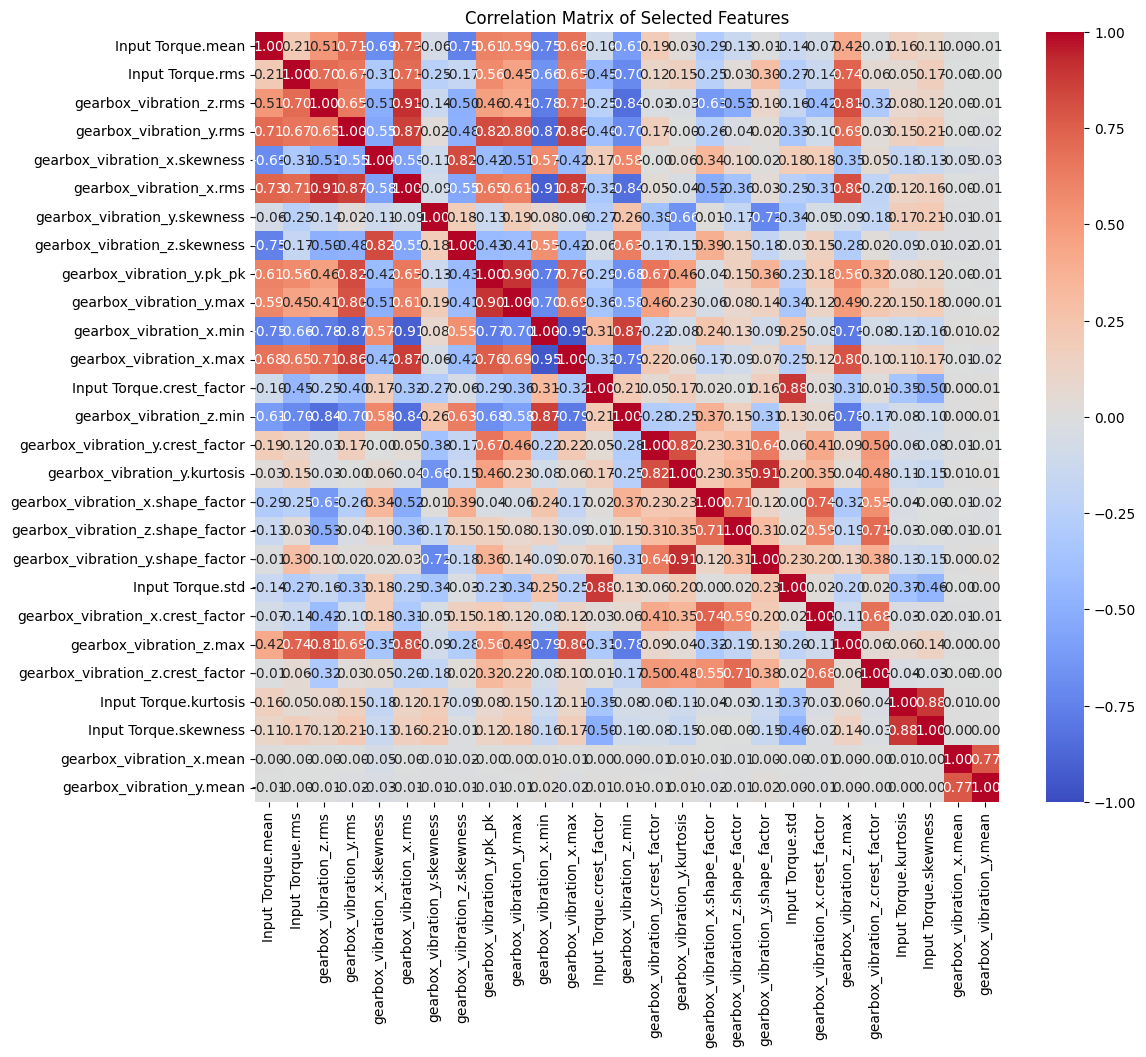

In [13]:

# Assuming X is your DataFrame with the features and mi_results is the DataFrame with MI Scores
# mi_results = pd.DataFrame({...})
# X = df.drop(columns=['fault'])

# Define the threshold for dropping highly correlated features
correlation_threshold = 0.95

# Sort the features by MI Score
sorted_features = mi_results.sort_values(by='MI Score', ascending=False)['Feature']

# Calculate the correlation matrix
correlation_matrix = X[sorted_features].corr()

# Initialize a list to hold the features to keep
features_to_keep = []

# Iterate through the sorted features
for feature in sorted_features:
    # Check if the feature is already in the list to keep
    if not any(correlation_matrix[feature][features_to_keep].abs() > correlation_threshold):
        # Add the feature to the list
        features_to_keep.append(feature)

# Filter the original DataFrame to keep only the selected features
X_filtered = X[features_to_keep]

# Display the filtered DataFrame
X_filtered

# Plot the correlation matrix of the filtered features
plt.figure(figsize=(12, 10))
sns.heatmap(X_filtered.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [14]:
X_filtered

,Input Torque.mean,Input Torque.rms,gearbox_vibration_z.rms,gearbox_vibration_y.rms,gearbox_vibration_x.skewness,gearbox_vibration_x.rms,gearbox_vibration_y.skewness,gearbox_vibration_z.skewness,gearbox_vibration_y.pk_pk,gearbox_vibration_y.max,...,gearbox_vibration_z.shape_factor,gearbox_vibration_y.shape_factor,Input Torque.std,gearbox_vibration_x.crest_factor,gearbox_vibration_z.max,gearbox_vibration_z.crest_factor,Input Torque.kurtosis,Input Torque.skewness,gearbox_vibration_x.mean,gearbox_vibration_y.mean
0,0.296231,0.345814,0.321518,0.185410,0.654060,0.171403,0.082803,0.377673,0.143278,0.151835,...,0.331754,0.588015,0.009428,0.366246,0.130430,0.141065,0.328475,0.324081,0.521226,0.589294
1,0.296154,0.345989,0.293548,0.175617,0.596754,0.138974,0.094456,0.334581,0.109765,0.070743,...,0.408023,0.519347,0.012416,0.295735,0.116994,0.318899,0.312702,0.320071,0.374558,0.405193
2,0.295611,0.347105,0.325443,0.213518,0.647973,0.200376,0.116572,0.381908,0.110251,0.111254,...,0.317580,0.600396,0.009837,0.224062,0.180129,0.233302,0.293375,0.311803,0.486711,0.463878
3,0.295275,0.347813,0.300109,0.139382,0.615706,0.136447,0.161709,0.349145,0.063259,0.081190,...,0.344502,0.321266,0.011395,0.146541,0.122700,0.348565,0.348087,0.342203,0.543351,0.436181
4,0.294894,0.348619,0.325048,0.197004,0.541218,0.175026,0.084965,0.338132,0.086342,0.069825,...,0.491495,0.452709,0.013812,0.410562,0.239125,0.341983,0.435657,0.454937,0.622783,0.678802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.967700,0.932783,0.525932,0.752695,0.470862,0.604857,0.577292,0.278543,0.675650,0.721924,...,0.584078,0.493133,0.016123,0.354018,0.572424,0.347392,0.442655,0.440993,0.281768,0.373137
2156,0.966839,0.930995,0.561819,0.886332,0.459503,0.674123,0.409261,0.287081,0.750491,0.553565,...,0.538249,0.538114,0.017435,0.872129,0.773937,0.658763,0.503780,0.546674,0.549341,0.454201
2157,0.966871,0.931063,0.568337,0.904519,0.483094,0.691794,0.366322,0.307838,1.000000,0.900931,...,0.699644,0.755507,0.018429,0.663004,0.766411,1.000000,0.391206,0.415706,0.693341,0.797759
2158,0.967363,0.932098,0.503135,0.772786,0.525966,0.590106,0.496247,0.374083,0.601395,0.495590,...,0.550915,0.418589,0.022896,0.452535,0.509662,0.312507,0.436180,0.489875,0.287656,0.258983


In [15]:


# Calculate the mutual information for each feature
mi_scores_filtered = mutual_info_classif(X_filtered, y)

# Create a DataFrame to hold the results
mi_results_filtered = pd.DataFrame({'Feature': X_filtered.columns, 'MI Score': mi_scores_filtered})

# Sort by MI Score
mi_results_filtered = mi_results_filtered.sort_values(by='MI Score', ascending=False)

# Display the results
mi_results_filtered

,Feature,MI Score
0,Input Torque.mean,1.390160
1,Input Torque.rms,1.187170
2,gearbox_vibration_z.rms,0.653408
3,gearbox_vibration_y.rms,0.647049
4,gearbox_vibration_x.skewness,0.641592
5,gearbox_vibration_x.rms,0.634883
6,gearbox_vibration_y.skewness,0.532742
7,gearbox_vibration_z.skewness,0.464424
8,gearbox_vibration_y.pk_pk,0.459747
9,gearbox_vibration_y.max,0.424462


Para comparar a eficiência das n features usar a variável features_relevantes (todas as 17)

Para as top n features, usar a função n_features_relevantes(n)

In [16]:
features_relevantes = mi_results_filtered['Feature'].tolist()   #17
def n_features_relevantes(n):    
    top_features_relevantes = mi_results_filtered.nlargest(n,'MI Score')['Feature'].tolist()
    return top_features_relevantes
top_features_relevantes = n_features_relevantes(40)
top_features_relevantes

['Input Torque.mean',
 'Input Torque.rms',
 'gearbox_vibration_z.rms',
 'gearbox_vibration_y.rms',
 'gearbox_vibration_x.skewness',
 'gearbox_vibration_x.rms',
 'gearbox_vibration_y.skewness',
 'gearbox_vibration_z.skewness',
 'gearbox_vibration_y.pk_pk',
 'gearbox_vibration_y.max',
 'gearbox_vibration_x.min',
 'gearbox_vibration_x.max',
 'Input Torque.crest_factor',
 'gearbox_vibration_z.min',
 'gearbox_vibration_y.crest_factor',
 'gearbox_vibration_y.kurtosis',
 'gearbox_vibration_x.shape_factor',
 'gearbox_vibration_z.shape_factor',
 'gearbox_vibration_y.shape_factor',
 'Input Torque.std',
 'gearbox_vibration_x.crest_factor',
 'gearbox_vibration_z.max',
 'gearbox_vibration_z.crest_factor',
 'Input Torque.kurtosis',
 'Input Torque.skewness',
 'gearbox_vibration_x.mean',
 'gearbox_vibration_y.mean']

## 3. Plotando Correlações Features vs Fault

### Definindo as Funções para plotar os gráficos
Utilizando as funções eda 4.5 como base, e alterando as legendas de apenas health - not health (0/1) para as possibilidades das variável alvo categória Fault

In [17]:
df_features_relevantes = df_features_org[top_features_relevantes + ['Fault','Torque']]#,'Degree']
df_features_relevantes
#plot_fault_categories_features(df_features_relevantes,'20Nm')

,Input Torque.mean,Input Torque.rms,gearbox_vibration_z.rms,gearbox_vibration_y.rms,gearbox_vibration_x.skewness,gearbox_vibration_x.rms,gearbox_vibration_y.skewness,gearbox_vibration_z.skewness,gearbox_vibration_y.pk_pk,gearbox_vibration_y.max,...,Input Torque.std,gearbox_vibration_x.crest_factor,gearbox_vibration_z.max,gearbox_vibration_z.crest_factor,Input Torque.kurtosis,Input Torque.skewness,gearbox_vibration_x.mean,gearbox_vibration_y.mean,Fault,Torque
0,0.296231,0.345814,0.321518,0.185410,0.654060,0.171403,0.082803,0.377673,0.143278,0.151835,...,0.009428,0.366246,0.130430,0.141065,0.328475,0.324081,0.521226,0.589294,gear_pitting,10Nm
1,0.296154,0.345989,0.293548,0.175617,0.596754,0.138974,0.094456,0.334581,0.109765,0.070743,...,0.012416,0.295735,0.116994,0.318899,0.312702,0.320071,0.374558,0.405193,gear_pitting,10Nm
2,0.295611,0.347105,0.325443,0.213518,0.647973,0.200376,0.116572,0.381908,0.110251,0.111254,...,0.009837,0.224062,0.180129,0.233302,0.293375,0.311803,0.486711,0.463878,gear_pitting,10Nm
3,0.295275,0.347813,0.300109,0.139382,0.615706,0.136447,0.161709,0.349145,0.063259,0.081190,...,0.011395,0.146541,0.122700,0.348565,0.348087,0.342203,0.543351,0.436181,gear_pitting,10Nm
4,0.294894,0.348619,0.325048,0.197004,0.541218,0.175026,0.084965,0.338132,0.086342,0.069825,...,0.013812,0.410562,0.239125,0.341983,0.435657,0.454937,0.622783,0.678802,gear_pitting,10Nm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.967700,0.932783,0.525932,0.752695,0.470862,0.604857,0.577292,0.278543,0.675650,0.721924,...,0.016123,0.354018,0.572424,0.347392,0.442655,0.440993,0.281768,0.373137,miss_teeth,20Nm
2156,0.966839,0.930995,0.561819,0.886332,0.459503,0.674123,0.409261,0.287081,0.750491,0.553565,...,0.017435,0.872129,0.773937,0.658763,0.503780,0.546674,0.549341,0.454201,miss_teeth,20Nm
2157,0.966871,0.931063,0.568337,0.904519,0.483094,0.691794,0.366322,0.307838,1.000000,0.900931,...,0.018429,0.663004,0.766411,1.000000,0.391206,0.415706,0.693341,0.797759,miss_teeth,20Nm
2158,0.967363,0.932098,0.503135,0.772786,0.525966,0.590106,0.496247,0.374083,0.601395,0.495590,...,0.022896,0.452535,0.509662,0.312507,0.436180,0.489875,0.287656,0.258983,miss_teeth,20Nm


#### Histograma

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fault_categories_features(df_features, torque):
    # Filter the dataframe based on 'Torque' value
    df_features_torque = df_features[df_features['Torque'] == torque]

    # List of unique fault categories
    fault_categories = df_features_torque['Fault'].unique()
    
    # List of colors for each fault category
    colors = plt.cm.get_cmap('tab10', len(fault_categories))
    
    # List of feature columns to plot, excluding non-numeric or specific columns
    features = df_features_torque.columns.drop(['Fault', 'Torque'])

    # Calculate the number of features and determine the number of rows and columns for the subplots
    n_features = len(features)
    n_cols = int(np.ceil(np.sqrt(n_features)))
    n_rows = int(np.ceil(n_features / n_cols))

    # Create subplots grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))  # Adjust figsize accordingly
    axs = axs.flatten()  # Flatten the array to easily index it with a single loop

    # Plot histograms for each feature in the grid
    for i, feature in enumerate(features):
        bins = 30
        for j, fault in enumerate(fault_categories):
            fault_data = df_features_torque[df_features_torque['Fault'] == fault]
            color = colors(j)
            axs[i].hist(fault_data[feature], bins, alpha=0.5, label=f'Fault {fault}', histtype='stepfilled', color=color)

            # Calculate the mean for the current fault category
            mean_value = fault_data[feature].mean()

            # Bounds
            upper_bound = fault_data[feature].max()
            lower_bound = fault_data[feature].min()

            # Draw a vertical line at the mean
            axs[i].axvline(mean_value, color=color, linestyle='dashed', linewidth=1)

            # Draw upper and lower bound lines 
            axs[i].axvline(upper_bound, color=color, linestyle='solid', linewidth=1)
            axs[i].axvline(lower_bound, color=color, linestyle='solid', linewidth=1)

        axs[i].legend(loc='upper right')
        axs[i].set_title(f'{feature} {torque}')
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Frequency')

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage:
#plot_fault_categories_features(df_features_relevantes, '20Nm')


#### Scatter Plot

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fault_categories_scatter(df_features, torque):
    # Filter the dataframe based on 'Torque' value
    df_features_torque = df_features[df_features['Torque'] == torque]

    # List of unique fault categories
    fault_categories = df_features_torque['Fault'].unique()
    
    # List of colors for each fault category
    colors = plt.cm.get_cmap('tab10', len(fault_categories))
    
    # List of feature columns to plot, excluding non-numeric or specific columns
    features = df_features_torque.columns.drop(['Fault', 'Torque'])

    # Calculate the number of features and determine the number of rows and columns for the subplots
    n_features = len(features)
    n_cols = int(np.ceil(np.sqrt(n_features)))
    n_rows = int(np.ceil(n_features / n_cols))

    # Create subplots grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))  # Adjust figsize accordingly
    axs = axs.flatten()  # Flatten the array to easily index it with a single loop

    # Plot scatter for each feature in the grid
    for i, feature in enumerate(features):
        for j, fault in enumerate(fault_categories):
            fault_data = df_features_torque[df_features_torque['Fault'] == fault]
            color = colors(j)
            axs[i].scatter(fault_data[feature], fault_data['Torque'], alpha=0.5, label=f'Fault {fault}', color=color)

            # Bounds
            upper_bound = fault_data[feature].max()
            lower_bound = fault_data[feature].min()
            # Draw upper and lower bound lines 
            axs[i].axvline(upper_bound, color=color, linestyle='solid', linewidth=1)
            axs[i].axvline(lower_bound, color=color, linestyle='solid', linewidth=1)
        
        axs[i].legend(loc='upper right')
        axs[i].set_title(f'{feature} {torque}')
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Torque')

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage:
#plot_fault_categories_scatter(df_features_relevantes, "20Nm")


#### Kernel Density Estimate (KDE)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_fault_categories_kde(df_features, torque):
    # Filter the dataframe based on 'Torque' value
    df_features_torque = df_features[df_features['Torque'] == torque]

    # List of unique fault categories
    fault_categories = df_features_torque['Fault'].unique()
    
    # List of colors for each fault category
    colors = plt.cm.get_cmap('tab10', len(fault_categories))
    
    # List of feature columns to plot, excluding non-numeric or specific columns
    features = df_features_torque.columns.drop(['Fault', 'Torque'])

    # Calculate the number of features and determine the number of rows and columns for the subplots
    n_features = len(features)
    n_cols = int(np.ceil(np.sqrt(n_features)))
    n_rows = int(np.ceil(n_features / n_cols))

    # Create subplots grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))  # Adjust figsize accordingly
    axs = axs.flatten()  # Flatten the array to easily index it with a single loop

    # Plot KDE for each feature in the grid
    for i, feature in enumerate(features):
        for j, fault in enumerate(fault_categories):
            fault_data = df_features_torque[df_features_torque['Fault'] == fault]
            color = colors(j)
            sns.kdeplot(fault_data[feature], ax=axs[i], fill=True, alpha=0.5, label=f'Fault {fault}', color=color)
        
        axs[i].legend(loc='upper right')
        axs[i].set_title(f'{feature} {torque}')
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Density')

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage:
#plot_fault_categories_kde(df_features_relevantes, '20Nm')


#### Pair Plot

In [21]:
def plot_fault_categories_pairplot(df_features,torque):
    # Filter the dataframe
    df_features_torque = df_features[df_features['Torque'] == torque]

    # List of unique fault categories
    fault_categories = df_features_torque['Fault'].unique()

    # Create a new column to hold the condition label
    df_features_torque['Condition'] = df_features_torque['Fault'].astype(str)

    # Drop the 'Torque' column if it's not needed for pair plotting
    combined_data = df_features_torque.drop(['Torque'], axis=1)

    # Use seaborn's pairplot to create a grid of scatter plots for each pair of features
    pair_plot = sns.pairplot(combined_data, hue='Condition', palette='tab10', 
                             vars=combined_data.columns.drop(['Fault', 'Condition']))
    
    pair_plot.fig.suptitle('Pair Plot of Features', y=1.02)  # Title and adjust title position
    plt.show()

# Example call with example data
#plot_fault_categories_pairplot(df_features_relevantes,'20Nm')


## 4. Criar regras do sistema baseado nas features Filtradas

In [22]:
top_features = df_features_relevantes.select_dtypes(include=['float64', 'int64']).columns.tolist()
top_features

['Input Torque.mean',
 'Input Torque.rms',
 'gearbox_vibration_z.rms',
 'gearbox_vibration_y.rms',
 'gearbox_vibration_x.skewness',
 'gearbox_vibration_x.rms',
 'gearbox_vibration_y.skewness',
 'gearbox_vibration_z.skewness',
 'gearbox_vibration_y.pk_pk',
 'gearbox_vibration_y.max',
 'gearbox_vibration_x.min',
 'gearbox_vibration_x.max',
 'Input Torque.crest_factor',
 'gearbox_vibration_z.min',
 'gearbox_vibration_y.crest_factor',
 'gearbox_vibration_y.kurtosis',
 'gearbox_vibration_x.shape_factor',
 'gearbox_vibration_z.shape_factor',
 'gearbox_vibration_y.shape_factor',
 'Input Torque.std',
 'gearbox_vibration_x.crest_factor',
 'gearbox_vibration_z.max',
 'gearbox_vibration_z.crest_factor',
 'Input Torque.kurtosis',
 'Input Torque.skewness',
 'gearbox_vibration_x.mean',
 'gearbox_vibration_y.mean']

## Funções SE

Perfeito, dicionário criado
- só vou ter que ter um pouco mais de atenção na hora de ler ele

parte escrita por mim, pft abaixo, parte comentada é do codigo original que  tenho que adaptar

função abaixo é do gpt, com o código comentado adaptado por ele, achoq ue ta certo na real, só conferir

Função perfeita funcionante abaixo!
1. Salva os parâmetros de bounds
2. Depois passa por cada linha avaliando se todas colunas(features) da quela linha se encaixam com tal fault, se se encaixar, ele dá o match.
3. Na hora do teste, só vou ter que mudar a linha:
   1. df_features_torque['ES Classification'] = df_features_torque.apply(lambda row: classify(row), axis=1)

### Função regra SE

In [23]:
import pandas as pd

def respostas(df_features, torque):
    # Filter the DataFrame based on the specified torque
    df_features_torque = df_features#[df_features['Torque'] == torque]
    
    # Get unique fault types and feature columns
    faults = df_features['Fault'].unique().tolist()
    top_features = df_features.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Initialize a dictionary to store min and max values for each feature and fault type
    feature_bounds = {fault: {} for fault in faults} # {fault:{vazio},fault2:{vazio}}

    # Calculate min and max values for each feature for each fault type
    for fault in faults:
        fault_df = df_features[df_features['Fault'] == fault] #filtrando as 160 linhas do df pra cada fault
        for ft in top_features:
            feature_bounds[fault][ft] = (fault_df[ft].min(), fault_df[ft].max()) #preenchendo so vazios do dict {fault:{feature:[min,max]}}
    # armazenando dict dentro de dict com valores de features bounds [dentro do filtro de cada 160 linhas(fault)]
    ########################## OK ###########################
    #for fault, bounds in feature_bounds.items():
        #print(f'fault = {fault}')
        #print(f'bounds = {bounds}')

    # Function to classify a single row # equivalente a repostas_dict
    def classify(row):  #cada linha vai ser passada por essa função
        for fault, bounds in feature_bounds.items():
            if all(bounds[feature][0] <= row[feature] <= bounds[feature][1] for feature in top_features):
                return fault
        return 'Unknown'

    # Apply the classification function to each row in the filtered DataFrame without using 'Fault'
    df_features_torque['Resposta SE'] = df_features_torque.apply(lambda row: classify(row), axis=1)

    return df_features_torque

# Example usage
# Assuming df_features_relevantes is your input DataFrame
# and features_fault_bounds is predefined
classified_df = respostas(df_features_relevantes, '10Nm').reset_index()
difference_df = classified_df[classified_df['Fault'] != classified_df['Resposta SE']]
#classified_df.loc[320]
#difference_df

### Análise dos valores se estão corretos
- foco nos erros cometidos pelo SE

In [24]:
def calculate_feature_bounds(df_features):
    # Get unique fault types and feature columns
    faults = df_features['Fault'].unique().tolist()
    top_features = df_features.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Initialize a list to store the bounds for each feature and fault type
    bounds_data = []

    # Calculate min and max values for each feature for each fault type
    for fault in faults:
        fault_df = df_features[df_features['Fault'] == fault]
        for ft in top_features:
            min_value = fault_df[ft].min()
            max_value = fault_df[ft].max()
            bounds_data.append({'fault': fault, 'feature': ft, 'min_value': min_value, 'max_value': max_value})

    # Convert the list of dictionaries to a DataFrame
    bounds_df = pd.DataFrame(bounds_data)

    return bounds_df

# Example usage
# Assuming df_features_relevantes is your input DataFrame
bounds_df = calculate_feature_bounds(df_features_relevantes)
bounds_df

,fault,feature,min_value,max_value
0,gear_pitting,Input Torque.mean,0.000000,0.490414
1,gear_pitting,Input Torque.rms,0.000000,0.962254
2,gear_pitting,gearbox_vibration_z.rms,0.000000,0.720724
3,gear_pitting,gearbox_vibration_y.rms,0.000000,0.527933
4,gear_pitting,gearbox_vibration_x.skewness,0.218956,1.000000
...,...,...,...,...
157,miss_teeth,gearbox_vibration_z.crest_factor,0.114577,1.000000
158,miss_teeth,Input Torque.kurtosis,0.306837,0.813007
159,miss_teeth,Input Torque.skewness,0.242616,0.809080
160,miss_teeth,gearbox_vibration_x.mean,0.012557,1.000000


Plot de linha dentro de todas features /faults

In [25]:
""""

def plot_feature_bounds(bounds_df, row_to_plot=None):
    # Get unique features and faults
    features = bounds_df['feature'].unique()
    faults = bounds_df['fault'].unique()

    # Create a color map for the faults
    colors = plt.cm.get_cmap('tab10', len(faults))

    # Create subplots in a 4x3 format
    fig, axes = plt.subplots(4, 3, figsize=(15, 20), sharey=True)
    axes = axes.flatten()

    # If there's only one feature, make sure axes is iterable
    if len(features) == 1:
        axes = [axes]

    # Plot min and max values for each feature
    for i, feature in enumerate(features):
        ax = axes[i]
        for j, fault in enumerate(faults):
            fault_bounds = bounds_df[(bounds_df['fault'] == fault) & (bounds_df['feature'] == feature)]
            min_value = fault_bounds['min_value'].values[0]
            max_value = fault_bounds['max_value'].values[0]
            ax.axvline(x=min_value, label=f'{fault} min', color=colors(j))
            ax.axvline(x=max_value, label=f'{fault} max', color=colors(j), linestyle='--')
        
        # Plot the row_to_plot values if provided
        if row_to_plot is not None and feature in row_to_plot:
            ax.plot(row_to_plot[feature], 0.5, 'o', color='red', markersize=10, label='Row Value')

        ax.set_title(f'Feature: {feature}')
        ax.set_xlabel('Value')
        ax.set_xlim(bounds_df['min_value'].min(), bounds_df['max_value'].max())

    # Hide any unused subplots
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    # Add a common y-label
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

    # Create a single legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(faults))

    # Adjust layout
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.show()

# Example usage
# Assuming bounds_df is the DataFrame from the calculate_feature_bounds function
# and classified_df is your DataFrame with classified rows
row_to_plot = classified_df.loc[320]
plot_feature_bounds(bounds_df, row_to_plot)

"""

'"\n\ndef plot_feature_bounds(bounds_df, row_to_plot=None):\n    # Get unique features and faults\n    features = bounds_df[\'feature\'].unique()\n    faults = bounds_df[\'fault\'].unique()\n\n    # Create a color map for the faults\n    colors = plt.cm.get_cmap(\'tab10\', len(faults))\n\n    # Create subplots in a 4x3 format\n    fig, axes = plt.subplots(4, 3, figsize=(15, 20), sharey=True)\n    axes = axes.flatten()\n\n    # If there\'s only one feature, make sure axes is iterable\n    if len(features) == 1:\n        axes = [axes]\n\n    # Plot min and max values for each feature\n    for i, feature in enumerate(features):\n        ax = axes[i]\n        for j, fault in enumerate(faults):\n            fault_bounds = bounds_df[(bounds_df[\'fault\'] == fault) & (bounds_df[\'feature\'] == feature)]\n            min_value = fault_bounds[\'min_value\'].values[0]\n            max_value = fault_bounds[\'max_value\'].values[0]\n            ax.axvline(x=min_value, label=f\'{fault} min\', color

Plot de linha dentro da feature/fault interesse.
Analisar x skewness do 320 vs 321. Um está fora - ok . O 321 tem overlap total, então classifica errado

In [26]:
"""
def plot_feature_bounds(bounds_df, row_to_plot=None):
    # Filter the faults to show
    filtered_faults = ['teeth_break', 'gear_wear']
    bounds_df = bounds_df[bounds_df['fault'].isin(filtered_faults)]
    
    # Get unique features and filtered faults
    features = bounds_df['feature'].unique()
    faults = bounds_df['fault'].unique()

    # Create a color map for the faults
    colors = plt.cm.get_cmap('tab10', len(faults))

    # Create subplots in a 4x3 format
    fig, axes = plt.subplots(4, 3, figsize=(15, 20), sharey=True)
    axes = axes.flatten()

    # If there's only one feature, make sure axes is iterable
    if len(features) == 1:
        axes = [axes]

    # Plot min and max values for each feature
    for i, feature in enumerate(features):
        ax = axes[i]
        for j, fault in enumerate(faults):
            fault_bounds = bounds_df[(bounds_df['fault'] == fault) & (bounds_df['feature'] == feature)]
            min_value = fault_bounds['min_value'].values[0]
            max_value = fault_bounds['max_value'].values[0]
            ax.axvline(x=min_value, label=f'{fault} min', color=colors(j))
            ax.axvline(x=max_value, label=f'{fault} max', color=colors(j))#, linestyle='--')
        
        # Plot the row_to_plot values if provided
        if row_to_plot is not None and feature in row_to_plot:
            ax.plot(row_to_plot[feature], 0.5, 'o', color='red', markersize=10, label='Row Value')

        ax.set_title(f'Feature: {feature}')
        ax.set_xlabel('Value')
        ax.set_xlim(bounds_df['min_value'].min(), bounds_df['max_value'].max())

    # Hide any unused subplots
    for i in range(len(features), len(axes)):
        fig.delaxes(axes[i])

    # Add a common y-label
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

    # Create a single legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(faults))

    # Adjust layout
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.show()

# Example usage
# Assuming bounds_df is the DataFrame from the calculate_feature_bounds function
# and classified_df is your DataFrame with classified rows
row_to_plot = classified_df.loc[321]
plot_feature_bounds(bounds_df, row_to_plot)
"""



"\ndef plot_feature_bounds(bounds_df, row_to_plot=None):\n    # Filter the faults to show\n    filtered_faults = ['teeth_break', 'gear_wear']\n    bounds_df = bounds_df[bounds_df['fault'].isin(filtered_faults)]\n    \n    # Get unique features and filtered faults\n    features = bounds_df['feature'].unique()\n    faults = bounds_df['fault'].unique()\n\n    # Create a color map for the faults\n    colors = plt.cm.get_cmap('tab10', len(faults))\n\n    # Create subplots in a 4x3 format\n    fig, axes = plt.subplots(4, 3, figsize=(15, 20), sharey=True)\n    axes = axes.flatten()\n\n    # If there's only one feature, make sure axes is iterable\n    if len(features) == 1:\n        axes = [axes]\n\n    # Plot min and max values for each feature\n    for i, feature in enumerate(features):\n        ax = axes[i]\n        for j, fault in enumerate(faults):\n            fault_bounds = bounds_df[(bounds_df['fault'] == fault) & (bounds_df['feature'] == feature)]\n            min_value = fault_bounds

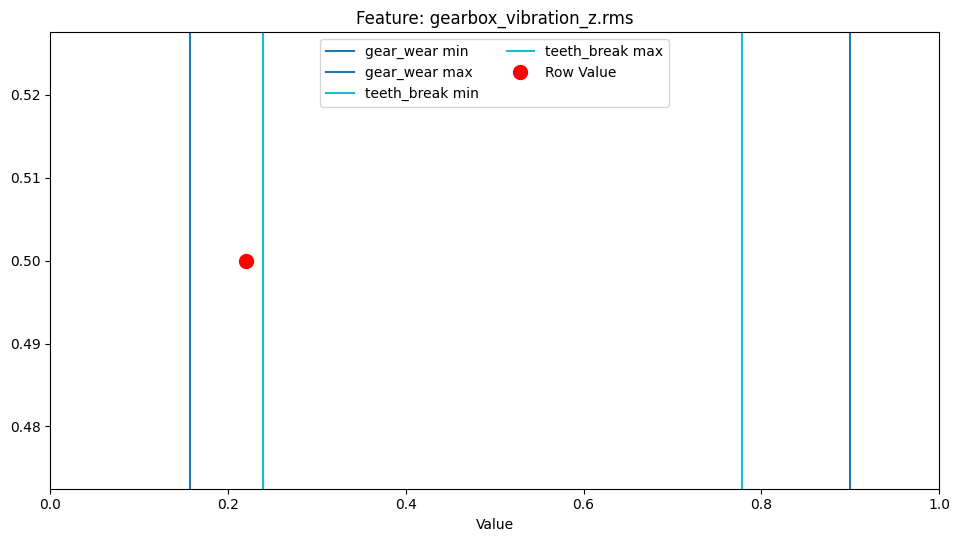

In [27]:
def plot_single_feature_bounds(bounds_df, row_to_plot=None):
    # Filter the faults to show
    filtered_faults = ['teeth_break', 'gear_wear']
    bounds_df = bounds_df[bounds_df['fault'].isin(filtered_faults)]
    
    # Get unique features and filtered faults
    features = bounds_df['feature'].unique()
    faults = bounds_df['fault'].unique()

    # Ensure the third feature exists
    if len(features) < 3:
        print("Not enough features to plot the third one.")
        return

    # Select the third feature
    feature_to_plot = features[2]

    # Create a color map for the faults
    colors = plt.cm.get_cmap('tab10', len(faults))

    # Create a single plot
    plt.figure(figsize=(10, 6))

    # Plot min and max values for the selected feature
    for j, fault in enumerate(faults):
        fault_bounds = bounds_df[(bounds_df['fault'] == fault) & (bounds_df['feature'] == feature_to_plot)]
        min_value = fault_bounds['min_value'].values[0]
        max_value = fault_bounds['max_value'].values[0]
        
        # Reduce the max value for 'gear_wear' by 0.1
        if fault == 'gear_wear':
            max_value -= 0.1

        plt.axvline(x=min_value, label=f'{fault} min', color=colors(j))
        plt.axvline(x=max_value, label=f'{fault} max', color=colors(j))#, linestyle='--')

    # Plot the row_to_plot values if provided
    if row_to_plot is not None and feature_to_plot in row_to_plot:
        plt.plot(row_to_plot[feature_to_plot], 0.5, 'o', color='red', markersize=10, label='Row Value')

    plt.title(f'Feature: {feature_to_plot}')
    plt.xlabel('Value')
    plt.xlim(bounds_df['min_value'].min(), bounds_df['max_value'].max())

    # Add y-label
    #plt.ylabel('Frequency')

    # Create a single legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper center', ncol=len(faults))

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.show()

# Example usage
# Assuming bounds_df is the DataFrame from the calculate_feature_bounds function
# and classified_df is your DataFrame with classified rows
row_to_plot = classified_df.loc[321]
plot_single_feature_bounds(bounds_df, row_to_plot)


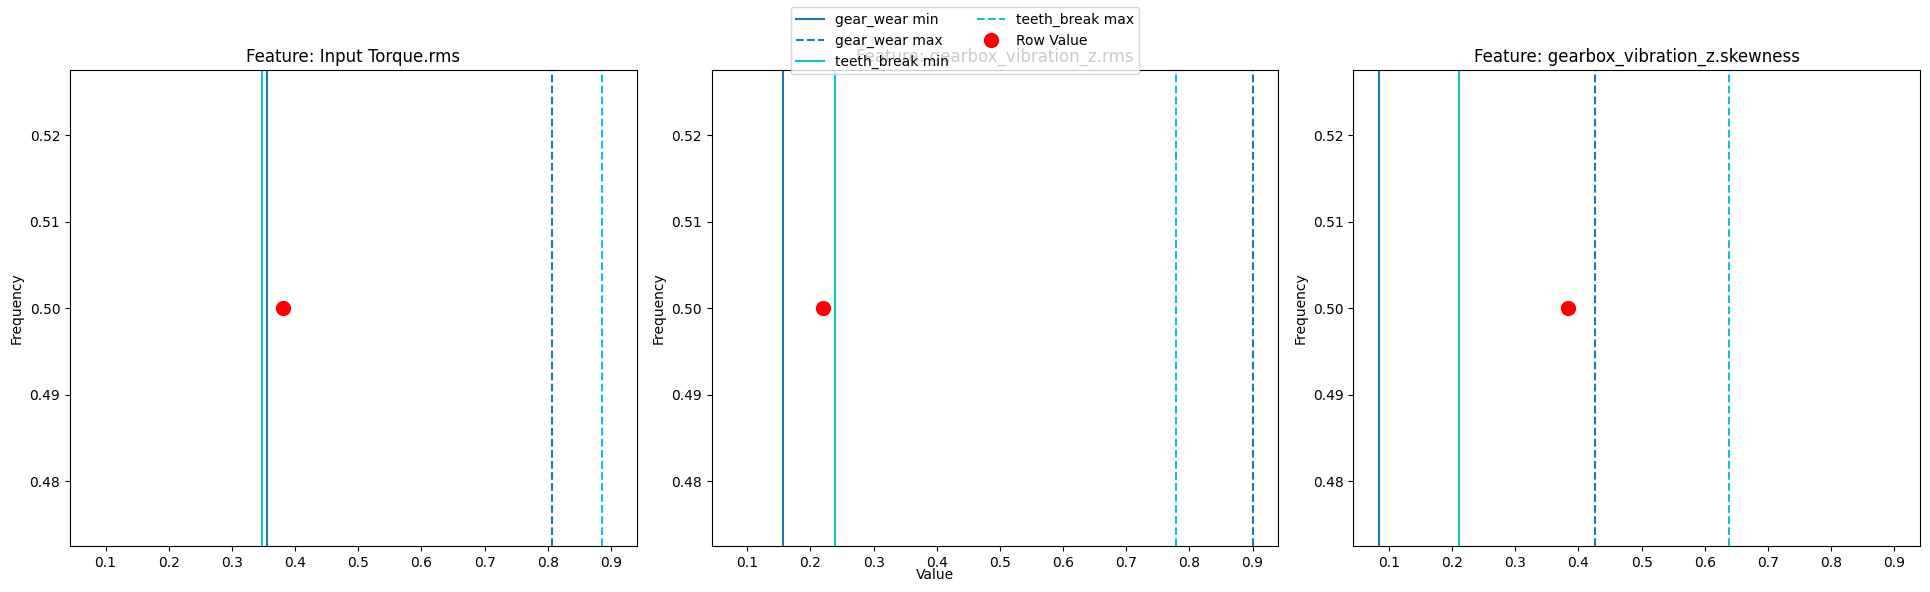

In [28]:
def plot_selected_feature_bounds(bounds_df, row_to_plot=None):
    # Filter the faults to show
    filtered_faults = ['teeth_break', 'gear_wear']
    bounds_df = bounds_df[bounds_df['fault'].isin(filtered_faults)]
    
    # Get unique features and filtered faults
    features = bounds_df['feature'].unique()
    faults = bounds_df['fault'].unique()

    # Ensure the required features exist
    if len(features) < 8:
        print("Not enough features to plot the required ones.")
        return

    # Select the features to plot
    features_to_plot = [features[1], features[2], features[7]]

    # Create a color map for the faults
    colors = plt.cm.get_cmap('tab10', len(faults))

    # Create subplots in a 3x1 format
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

    # Plot min and max values for the selected features
    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        for j, fault in enumerate(faults):
            fault_bounds = bounds_df[(bounds_df['fault'] == fault) & (bounds_df['feature'] == feature)]
            min_value = fault_bounds['min_value'].values[0]
            max_value = fault_bounds['max_value'].values[0]
            
            # Reduce the max value for 'gear_wear' by 0.1
            if fault == 'gear_wear':
                max_value -= 0.1

            ax.axvline(x=min_value, label=f'{fault} min', color=colors(j))
            ax.axvline(x=max_value, label=f'{fault} max', color=colors(j), linestyle='--')
        
        # Plot the row_to_plot values if provided
        if row_to_plot is not None and feature in row_to_plot:
            ax.plot(row_to_plot[feature], 0.5, 'o', color='red', markersize=10, label='Row Value')

        ax.set_title(f'Feature: {feature}')
        ax.set_ylabel('Frequency')

    # Add a common x-label
    fig.text(0.5, 0.04, 'Value', ha='center')

    # Create a single legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(faults))

    # Adjust layout
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.show()

# Example usage
# Assuming bounds_df is the DataFrame from the calculate_feature_bounds function
# and classified_df is your DataFrame with classified rows
row_to_plot = classified_df.loc[321]
plot_selected_feature_bounds(bounds_df, row_to_plot)


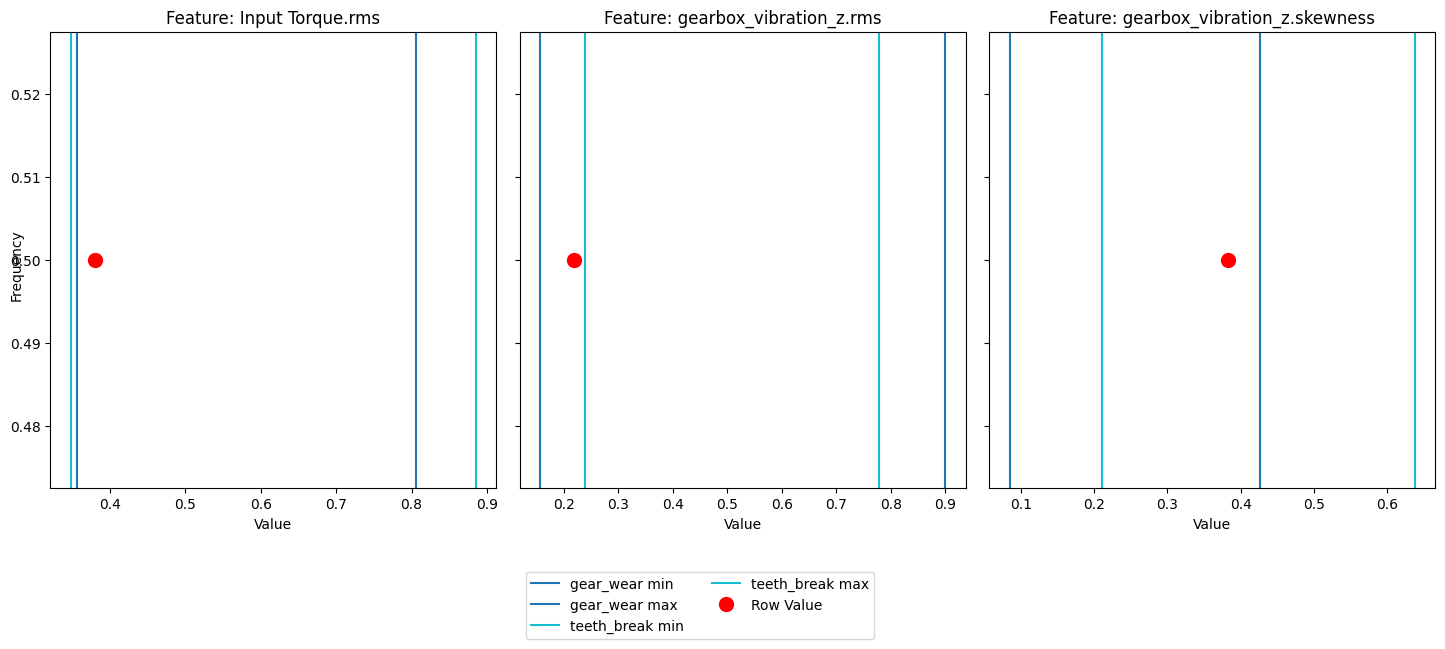

In [29]:
def plot_selected_feature_bounds(bounds_df, row_to_plot=None):
    # Filter the faults to show
    filtered_faults = ['teeth_break', 'gear_wear']
    bounds_df = bounds_df[bounds_df['fault'].isin(filtered_faults)]
    
    # Get unique features and filtered faults
    features = bounds_df['feature'].unique()
    faults = bounds_df['fault'].unique()

    # Ensure the required features exist
    if len(features) < 8:
        print("Not enough features to plot the required ones.")
        return

    # Select the features to plot
    features_to_plot = [features[1], features[2], features[7]]

    # Create a color map for the faults
    colors = plt.cm.get_cmap('tab10', len(faults))

    # Create subplots in a 1x3 format
    fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

    # Plot min and max values for the selected features
    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        for j, fault in enumerate(faults):
            fault_bounds = bounds_df[(bounds_df['fault'] == fault) & (bounds_df['feature'] == feature)]
            min_value = fault_bounds['min_value'].values[0]
            max_value = fault_bounds['max_value'].values[0]
            
            # Reduce the max value for 'gear_wear' by 0.1
            if fault == 'gear_wear':
                max_value -= 0.1

            ax.axvline(x=min_value, label=f'{fault} min', color=colors(j))#, linestyle='--')
            ax.axvline(x=max_value, label=f'{fault} max', color=colors(j))#, linestyle='--')
        
        # Plot the row_to_plot values if provided
        if row_to_plot is not None and feature in row_to_plot:
            ax.plot(row_to_plot[feature], 0.5, 'o', color='red', markersize=10, label='Row Value')

        ax.set_title(f'Feature: {feature}')
        ax.set_xlabel('Value')

    # Add a common y-label
    fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

    # Create a single legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.00), ncol=len(faults))

    # Adjust layout
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.show()

# Example usage
# Assuming bounds_df is the DataFrame from the calculate_feature_bounds function
# and classified_df is your DataFrame with classified rows
row_to_plot = classified_df.loc[321]
plot_selected_feature_bounds(bounds_df, row_to_plot)


## Função Teste

### Evaluate Metrics

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

def plot_confusion_matrix(y_true, y_pred, labels):
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')
    ax.set_title('Matriz de Confusão')
    
    plt.tight_layout()
    plt.show()
    
    return cm

def calculate_metrics(y_true, y_pred, labels):
    accuracy = np.trace(confusion_matrix(y_true, y_pred, labels=labels)) / np.sum(confusion_matrix(y_true, y_pred, labels=labels))
    precision = precision_score(y_true, y_pred, average='macro')  # Changed to 'weighted' for multi-class
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f'Accuracy: {accuracy:.2%}')
    print(f'Precision: {precision:.2%}')
    print(f'Recall: {recall:.2%}')
    print(f'F1 Score: {f1:.2%}')
    print(classification_report(y_true, y_pred, target_names=labels))

    return accuracy, precision, recall, f1

def plot_roc_curve(y_true, y_prob, labels):
    # Note: ROC curve is not typically used for multi-class without significant changes.
    plt.figure(figsize=(10, 6))
    for i, label in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_true == label, y_prob[:, i])
        auc = roc_auc_score(y_true == label, y_prob[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {auc:.2f}) for {label}')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = y_true.unique().tolist()  # Automatically find all unique labels
    
    cm = plot_confusion_matrix(y_true, y_pred, labels)
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred, labels)
    
    if 'Prob' in features_resposta.columns:  # Assuming you have probability scores
        y_prob = np.array(features_resposta['Prob'].tolist())
        plot_roc_curve(y_true, y_prob, labels)
    else:
        print("Probability scores not found in features_resposta DataFrame.")
    
    # Select numeric types from the DataFrame
    df_features_n = features_resposta.select_dtypes(include=['float64', 'int64'])  # Select numeric columns
    print(f'Valores para {len(df_features_n.columns)} features analisadas')
    return accuracy, precision, recall, f1

#metrics = evaluate_model(df_features_resposta)

In [31]:
# Treino e teste
df_features_relevantes = df_features_org[top_features_relevantes + ['Fault','Torque']]#,'Degree']
df_features_relevantes_teste = df_features_org_teste[top_features_relevantes + ['Fault','Torque']]#,'Degree']

df_features_resposta = respostas(df_features_relevantes, '10Nm').reset_index()
df_features_resposta_teste = respostas(df_features_relevantes_teste, '10Nm').reset_index()

#df_features_relevantes_teste
#df_features_resposta_teste
def gerar_features_resposta_treino(n_features):
    top_features_relevantes = n_features_relevantes(n_features)
    df_features_relevantes = df_features_org[top_features_relevantes + ['Fault','Torque']]
    df_features_resposta = respostas(df_features_relevantes, '10Nm').reset_index()
    return df_features_resposta
# Só tenho 20Nm para 3 testes

def gerar_features_resposta_teste(n_features):
    top_features_relevantes = n_features_relevantes(n_features)
    print(f'Iteration {n_features}: Selected top features: {top_features_relevantes}')  # Log selected features
    df_features_relevantes_teste = df_features_org_teste[top_features_relevantes + ['Fault','Torque']]
    df_features_resposta_teste = respostas(df_features_relevantes_teste, '10Nm').reset_index()
    return df_features_resposta_teste

Iteration 28: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox_vibration_y.max', 'gearbox_vibration_x.min', 'gearbox_vibration_x.max', 'Input Torque.crest_factor', 'gearbox_vibration_z.min', 'gearbox_vibration_y.crest_factor', 'gearbox_vibration_y.kurtosis', 'gearbox_vibration_x.shape_factor', 'gearbox_vibration_z.shape_factor', 'gearbox_vibration_y.shape_factor', 'Input Torque.std', 'gearbox_vibration_x.crest_factor', 'gearbox_vibration_z.max', 'gearbox_vibration_z.crest_factor', 'Input Torque.kurtosis', 'Input Torque.skewness', 'gearbox_vibration_x.mean', 'gearbox_vibration_y.mean']


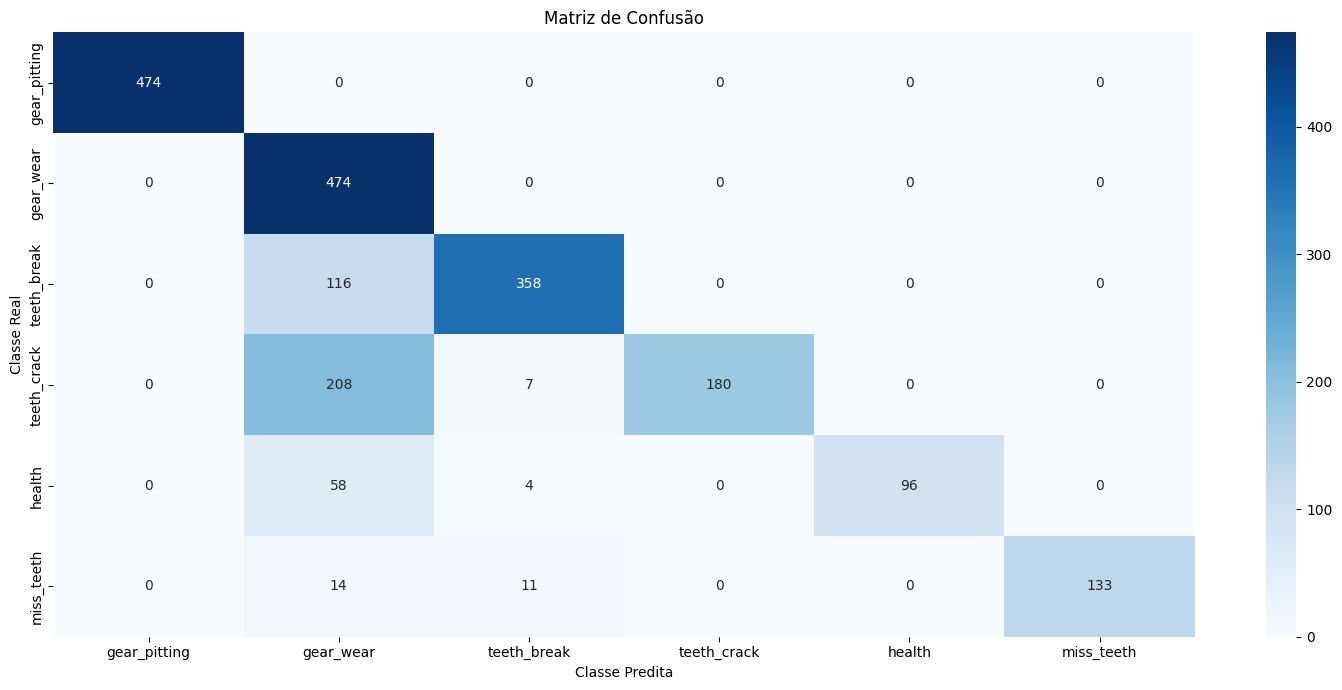

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas


(0.804031879981247, 0.9144888082274653, 0.7767229254571028, 0.8066410754023571)

In [32]:
#evaluate_model(df_features_resposta)
#evaluate_model(gerar_features_resposta_treino(1)) # melhor resultado 16 features
evaluate_model(gerar_features_resposta_teste(28)) # melhor resultado 16 features

#for n in range(0,40):

#evaluate_model(gerar_features_resposta_teste(n))


# Resultados
- tá dando 100% para o teste com 10 features

In [33]:
df_features_resposta.drop(columns='index')#['Fault']

,Input Torque.mean,Input Torque.rms,gearbox_vibration_z.rms,gearbox_vibration_y.rms,gearbox_vibration_x.skewness,gearbox_vibration_x.rms,gearbox_vibration_y.skewness,gearbox_vibration_z.skewness,gearbox_vibration_y.pk_pk,gearbox_vibration_y.max,...,gearbox_vibration_x.crest_factor,gearbox_vibration_z.max,gearbox_vibration_z.crest_factor,Input Torque.kurtosis,Input Torque.skewness,gearbox_vibration_x.mean,gearbox_vibration_y.mean,Fault,Torque,Resposta SE
0,0.296231,0.345814,0.321518,0.185410,0.654060,0.171403,0.082803,0.377673,0.143278,0.151835,...,0.366246,0.130430,0.141065,0.328475,0.324081,0.521226,0.589294,gear_pitting,10Nm,gear_pitting
1,0.296154,0.345989,0.293548,0.175617,0.596754,0.138974,0.094456,0.334581,0.109765,0.070743,...,0.295735,0.116994,0.318899,0.312702,0.320071,0.374558,0.405193,gear_pitting,10Nm,gear_pitting
2,0.295611,0.347105,0.325443,0.213518,0.647973,0.200376,0.116572,0.381908,0.110251,0.111254,...,0.224062,0.180129,0.233302,0.293375,0.311803,0.486711,0.463878,gear_pitting,10Nm,gear_pitting
3,0.295275,0.347813,0.300109,0.139382,0.615706,0.136447,0.161709,0.349145,0.063259,0.081190,...,0.146541,0.122700,0.348565,0.348087,0.342203,0.543351,0.436181,gear_pitting,10Nm,gear_pitting
4,0.294894,0.348619,0.325048,0.197004,0.541218,0.175026,0.084965,0.338132,0.086342,0.069825,...,0.410562,0.239125,0.341983,0.435657,0.454937,0.622783,0.678802,gear_pitting,10Nm,gear_pitting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.967700,0.932783,0.525932,0.752695,0.470862,0.604857,0.577292,0.278543,0.675650,0.721924,...,0.354018,0.572424,0.347392,0.442655,0.440993,0.281768,0.373137,miss_teeth,20Nm,miss_teeth
2156,0.966839,0.930995,0.561819,0.886332,0.459503,0.674123,0.409261,0.287081,0.750491,0.553565,...,0.872129,0.773937,0.658763,0.503780,0.546674,0.549341,0.454201,miss_teeth,20Nm,miss_teeth
2157,0.966871,0.931063,0.568337,0.904519,0.483094,0.691794,0.366322,0.307838,1.000000,0.900931,...,0.663004,0.766411,1.000000,0.391206,0.415706,0.693341,0.797759,miss_teeth,20Nm,miss_teeth
2158,0.967363,0.932098,0.503135,0.772786,0.525966,0.590106,0.496247,0.374083,0.601395,0.495590,...,0.452535,0.509662,0.312507,0.436180,0.489875,0.287656,0.258983,miss_teeth,20Nm,miss_teeth


Iteration 1: Selected top features: ['Input Torque.mean']
Accuracy: 52.59%
Precision: 63.22%
Recall: 45.22%
F1 Score: 39.79%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       480
   gear_wear       0.34      1.00      0.50       480
 teeth_break       0.50      0.50      0.50       160
 teeth_crack       0.00      0.00      0.00       160
      health       0.96      0.13      0.23       480
  miss_teeth       1.00      0.08      0.15       400

    accuracy                           0.53      2160
   macro avg       0.63      0.45      0.40      2160
weighted avg       0.73      0.53      0.45      2160

Accuracy: 56.40%
Precision: 63.71%
Recall: 47.99%
F1 Score: 43.56%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.36      1.00      0.53       474
 teeth_break       0.50      0.50      0.50       158
 teeth_crack       0.00      0.00      0.00     

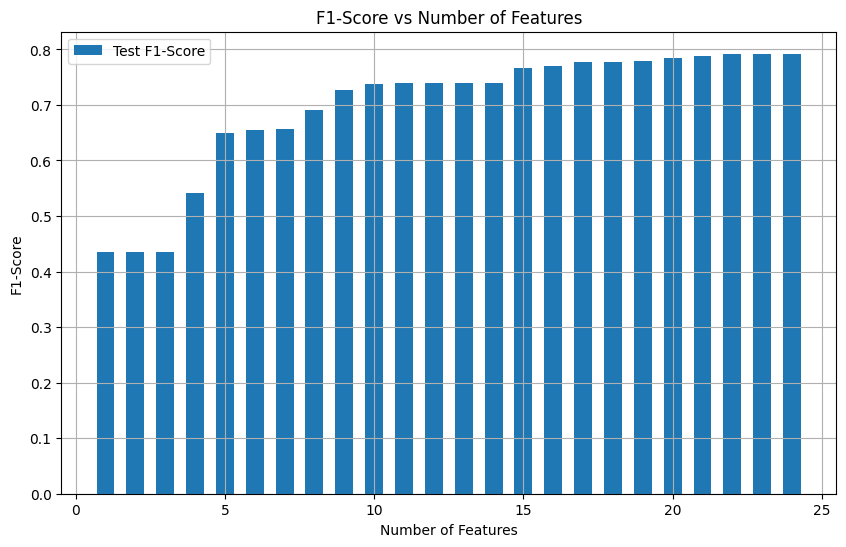

In [34]:
# Function to evaluate model and return F1-score
def evaluate_model_f1score(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = y_true.unique().tolist()  # Automatically find all unique labels
    
    #cm = confusion_matrix(y_true, y_pred, labels)
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred, labels)
    
    return f1



# Loop through number of features from 1 to 40 and evaluate F1-scores
def evaluate_feature_selection():
    num_features_range = range(1, 25)
    f1_scores_train = []
    f1_scores_test = []

    for num_features in num_features_range:
        # Get training and test data
        df_features_resposta = gerar_features_resposta_treino(num_features)  # Replace with your actual training data function
        df_features_resposta_t = gerar_features_resposta_teste(num_features)  # Replace with your actual test data function
        
        # Evaluate the model on training data
        f1_train = evaluate_model_f1score(df_features_resposta)
        f1_scores_train.append(f1_train)
        
        # Evaluate the model on test data
        f1_test = evaluate_model_f1score(df_features_resposta_t)
        f1_scores_test.append(f1_test)
    print(f1_scores_train)
    print(f1_scores_test)
    
    # Plotting F1-Score comparison
    # plt.figure(figsize=(10, 6))
    # plt.plot(num_features_range, f1_scores_train, label='Training F1-Score')
    # plt.plot(num_features_range, f1_scores_test, label='Test F1-Score')
    # plt.xlabel('Number of Features')
    # plt.ylabel('F1-Score')
    # plt.title('F1-Score vs Number of Features')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    # Creating the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(num_features_range, f1_scores_test, width=0.6, label='Test F1-Score')
    plt.xlabel('Number of Features')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
evaluate_feature_selection()

## Treino vs Teste
- como tem o health do treino e no teste iguais, to com a impressão de esse data leaking ta dando 100%

## Torque 10 vs 20
- Testar oq rola se colocar pra treinar incluindo torque de 10 e 20N

## Inicial vs Final
Quando eu treino com o inicial e testo com o final da um resultado interessante.
Me permitira treinas com todas possibilidades e testar todas

# Finalizar
- Criar função para executar as etapas variando as etapas que quero
- Incluir ou não torque, 10 e 20 Nm
- Variar o número de features


Iteration 0: Selected top features: []


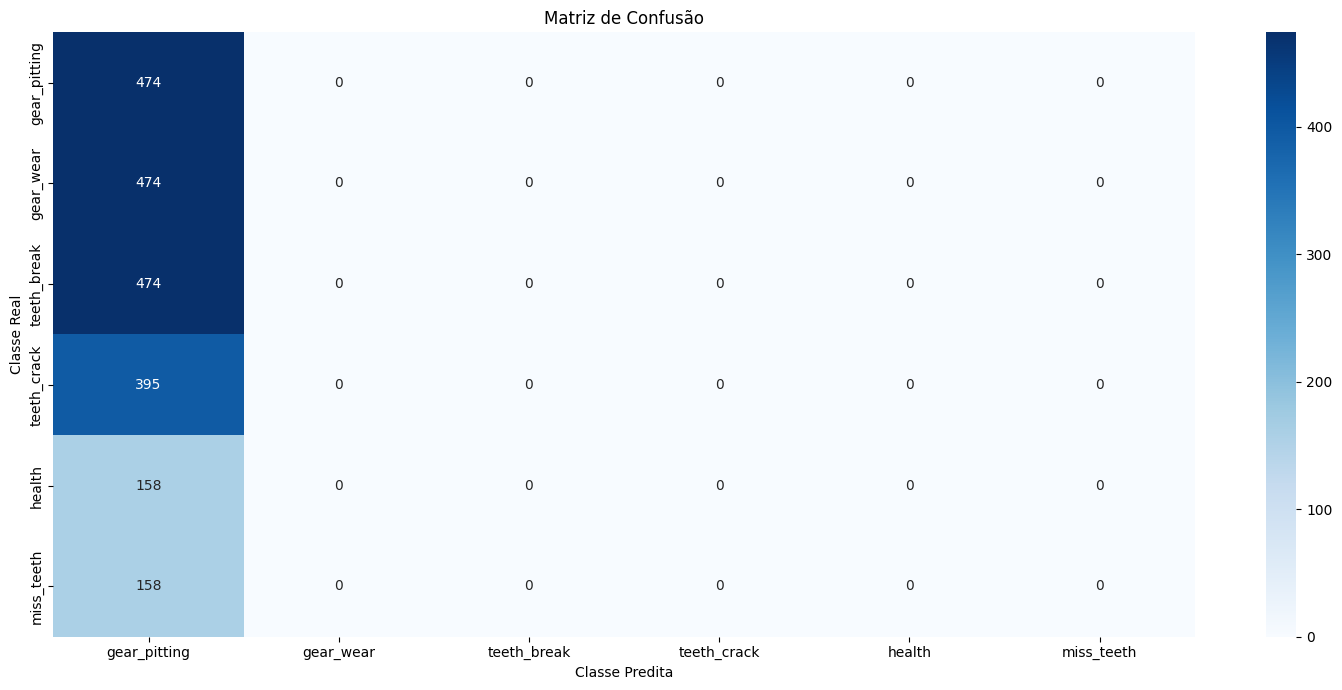

Accuracy: 22.22%
Precision: 3.70%
Recall: 16.67%
F1 Score: 6.06%
              precision    recall  f1-score   support

gear_pitting       0.22      1.00      0.36       474
   gear_wear       0.00      0.00      0.00       474
 teeth_break       0.00      0.00      0.00       158
 teeth_crack       0.00      0.00      0.00       158
      health       0.00      0.00      0.00       474
  miss_teeth       0.00      0.00      0.00       395

    accuracy                           0.22      2133
   macro avg       0.04      0.17      0.06      2133
weighted avg       0.05      0.22      0.08      2133

Probability scores not found in features_resposta DataFrame.
Valores para 1 features analisadas
Iteration 1: Selected top features: ['Input Torque.mean']


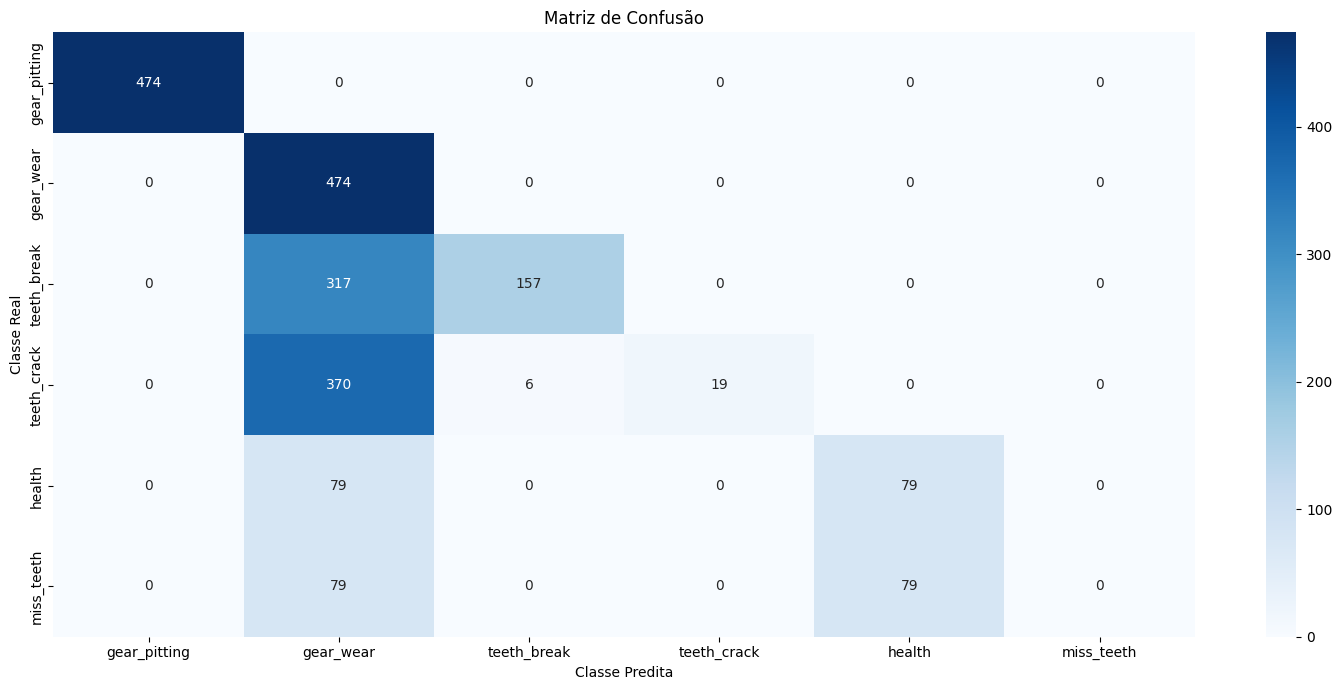

Accuracy: 56.40%
Precision: 63.71%
Recall: 47.99%
F1 Score: 43.56%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.36      1.00      0.53       474
 teeth_break       0.50      0.50      0.50       158
 teeth_crack       0.00      0.00      0.00       158
      health       0.96      0.33      0.49       474
  miss_teeth       1.00      0.05      0.09       395

    accuracy                           0.56      2133
   macro avg       0.64      0.48      0.44      2133
weighted avg       0.74      0.56      0.50      2133

Probability scores not found in features_resposta DataFrame.
Valores para 2 features analisadas
Iteration 2: Selected top features: ['Input Torque.mean', 'Input Torque.rms']


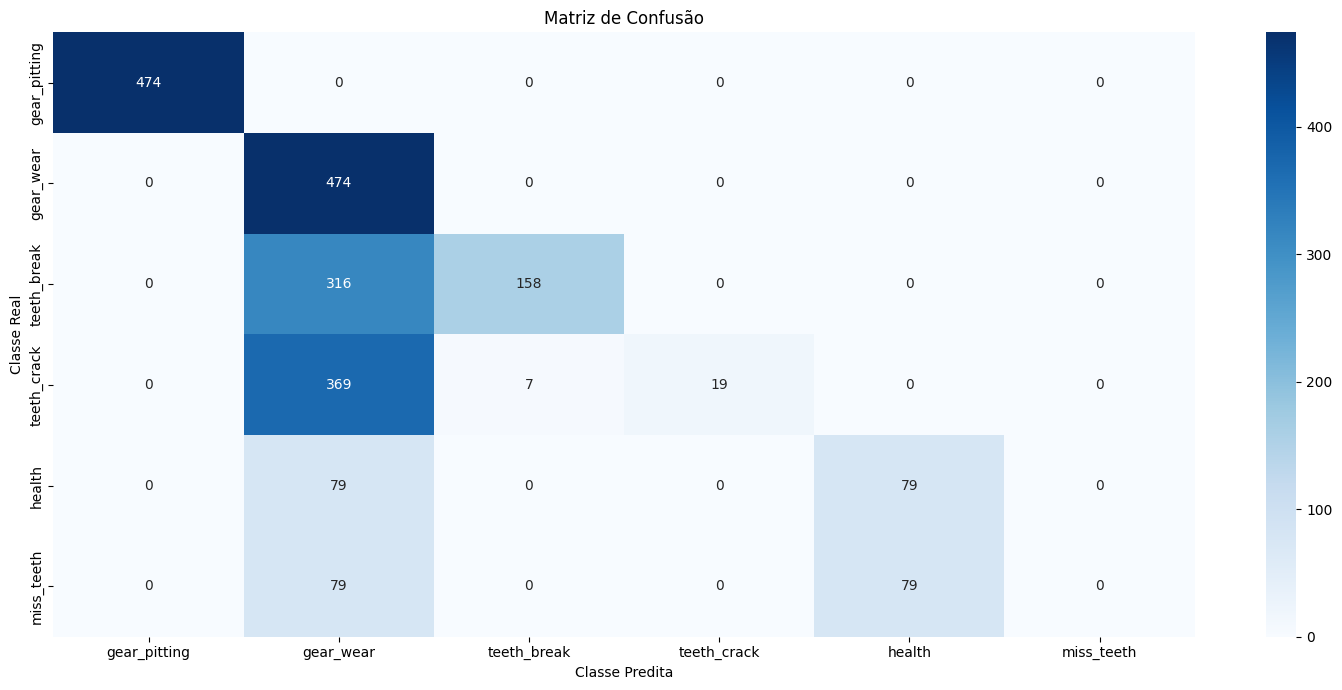

Accuracy: 56.45%
Precision: 63.62%
Recall: 48.02%
F1 Score: 43.59%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.36      1.00      0.53       474
 teeth_break       0.50      0.50      0.50       158
 teeth_crack       0.00      0.00      0.00       158
      health       0.96      0.33      0.49       474
  miss_teeth       1.00      0.05      0.09       395

    accuracy                           0.56      2133
   macro avg       0.64      0.48      0.44      2133
weighted avg       0.74      0.56      0.50      2133

Probability scores not found in features_resposta DataFrame.
Valores para 3 features analisadas
Iteration 3: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms']


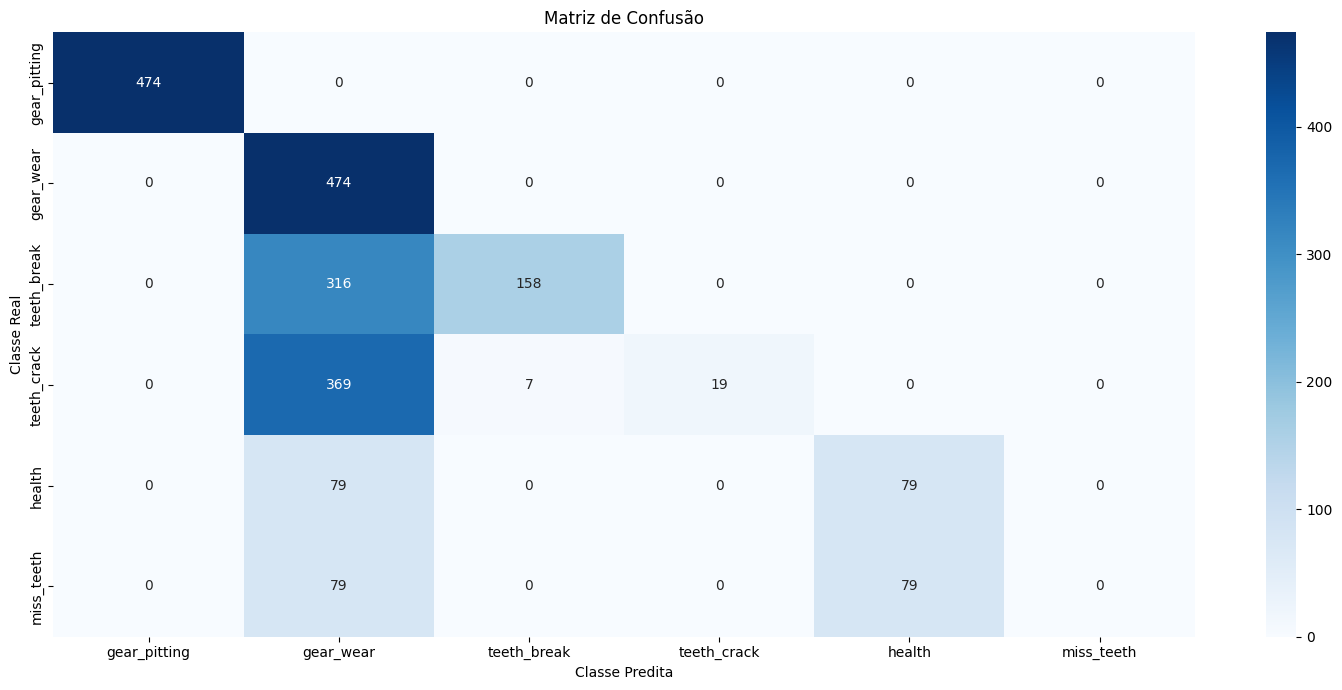

Accuracy: 56.45%
Precision: 63.62%
Recall: 48.02%
F1 Score: 43.59%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.36      1.00      0.53       474
 teeth_break       0.50      0.50      0.50       158
 teeth_crack       0.00      0.00      0.00       158
      health       0.96      0.33      0.49       474
  miss_teeth       1.00      0.05      0.09       395

    accuracy                           0.56      2133
   macro avg       0.64      0.48      0.44      2133
weighted avg       0.74      0.56      0.50      2133

Probability scores not found in features_resposta DataFrame.
Valores para 4 features analisadas
Iteration 4: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms']


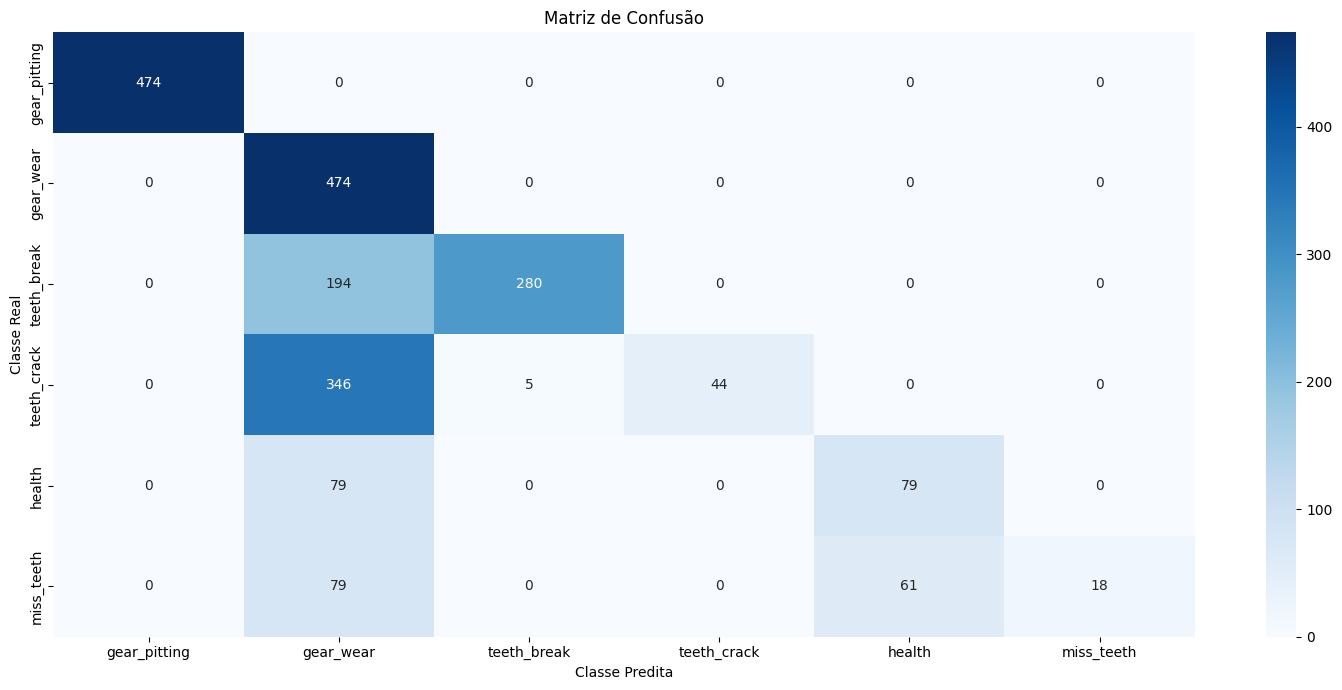

Accuracy: 64.18%
Precision: 82.52%
Recall: 55.27%
F1 Score: 54.15%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.40      1.00      0.58       474
 teeth_break       0.56      0.50      0.53       158
 teeth_crack       1.00      0.11      0.20       158
      health       0.98      0.59      0.74       474
  miss_teeth       1.00      0.11      0.20       395

    accuracy                           0.64      2133
   macro avg       0.83      0.55      0.54      2133
weighted avg       0.83      0.64      0.61      2133

Probability scores not found in features_resposta DataFrame.
Valores para 5 features analisadas
Iteration 5: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness']


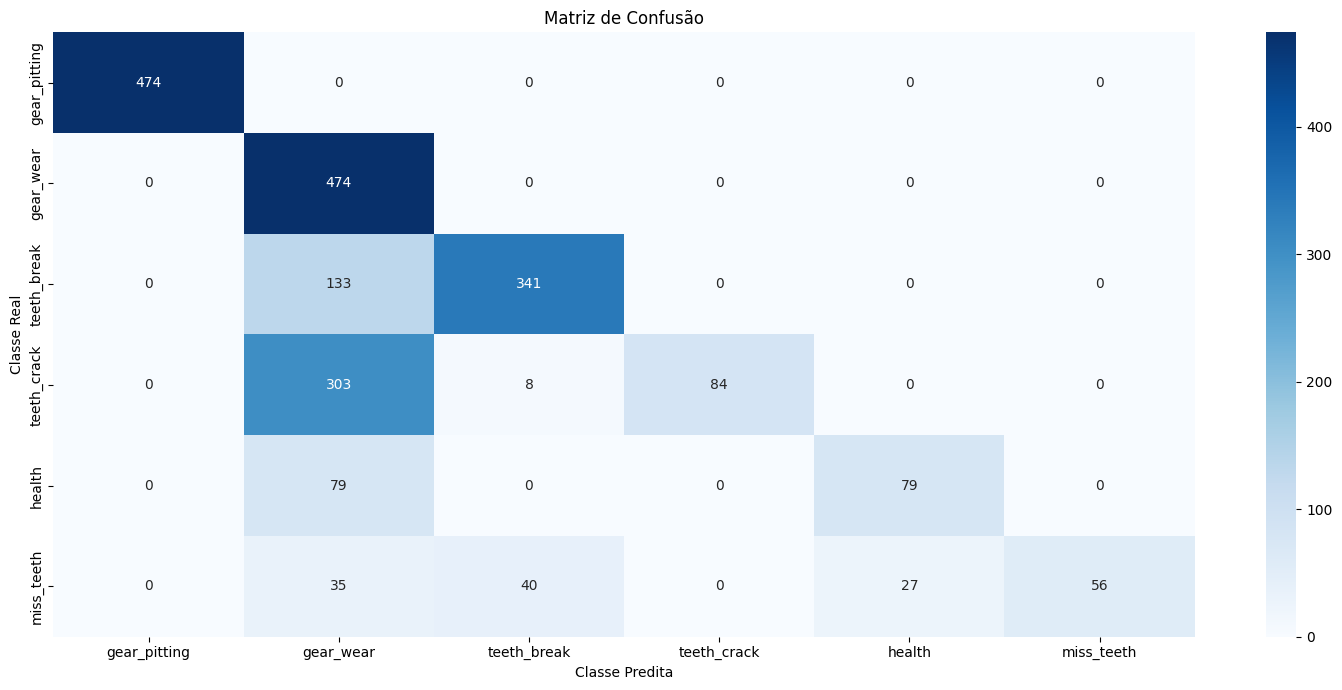

Accuracy: 70.70%
Precision: 84.75%
Recall: 63.11%
F1 Score: 64.93%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.46      1.00      0.63       474
 teeth_break       0.75      0.50      0.60       158
 teeth_crack       1.00      0.35      0.52       158
      health       0.88      0.72      0.79       474
  miss_teeth       1.00      0.21      0.35       395

    accuracy                           0.71      2133
   macro avg       0.85      0.63      0.65      2133
weighted avg       0.83      0.71      0.69      2133

Probability scores not found in features_resposta DataFrame.
Valores para 6 features analisadas
Iteration 6: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms']


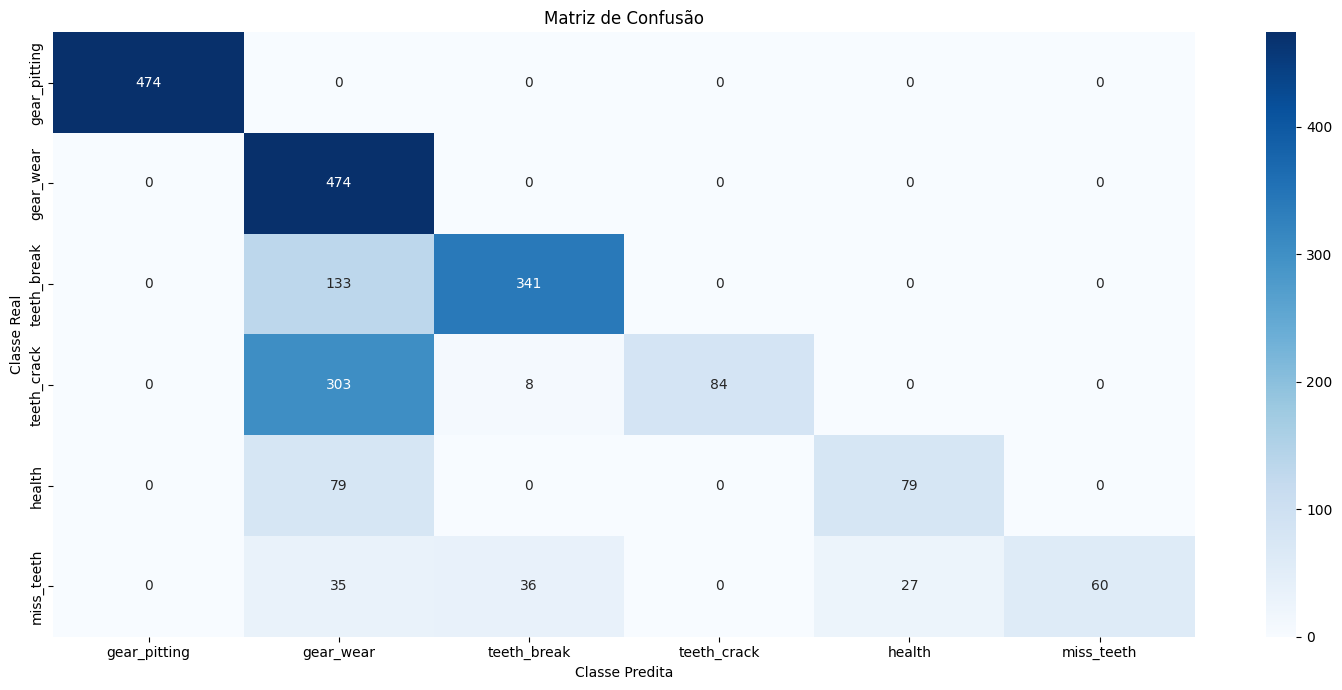

Accuracy: 70.89%
Precision: 84.90%
Recall: 63.53%
F1 Score: 65.44%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.46      1.00      0.63       474
 teeth_break       0.75      0.50      0.60       158
 teeth_crack       1.00      0.38      0.55       158
      health       0.89      0.72      0.79       474
  miss_teeth       1.00      0.21      0.35       395

    accuracy                           0.71      2133
   macro avg       0.85      0.64      0.65      2133
weighted avg       0.84      0.71      0.69      2133

Probability scores not found in features_resposta DataFrame.
Valores para 7 features analisadas
Iteration 7: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness']


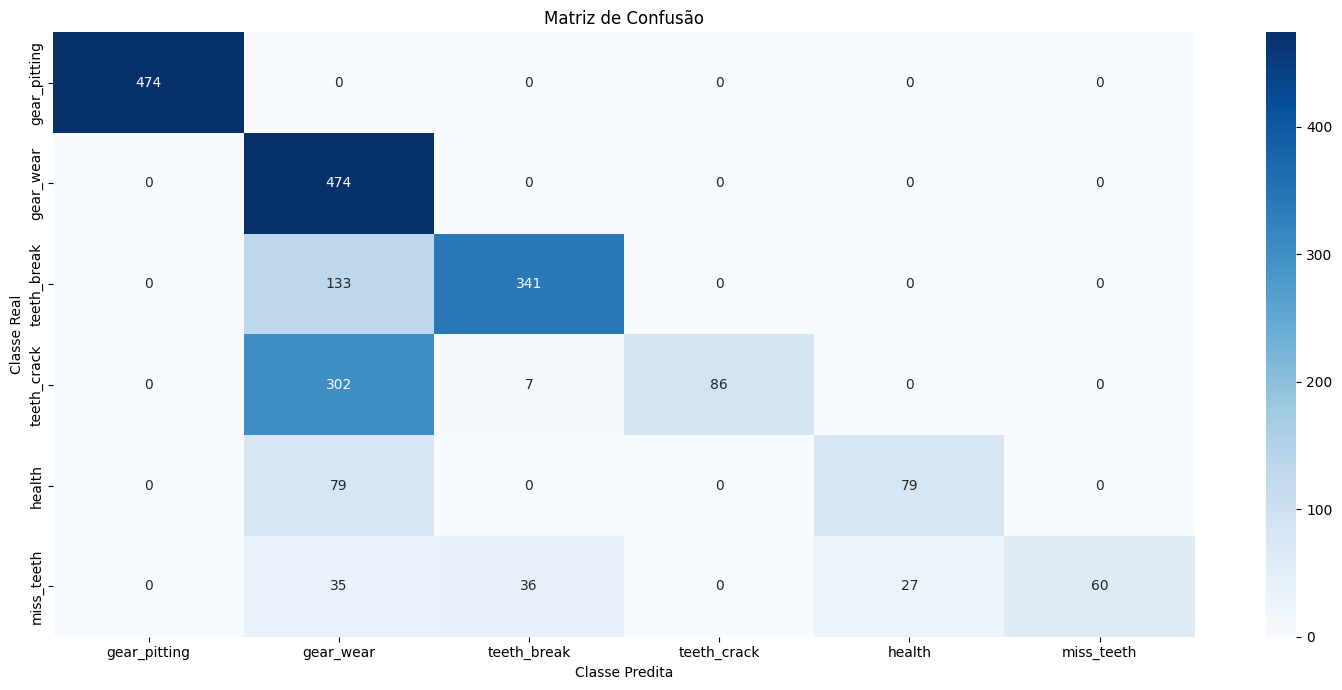

Accuracy: 70.98%
Precision: 84.94%
Recall: 63.61%
F1 Score: 65.58%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.46      1.00      0.63       474
 teeth_break       0.75      0.50      0.60       158
 teeth_crack       1.00      0.38      0.55       158
      health       0.89      0.72      0.79       474
  miss_teeth       1.00      0.22      0.36       395

    accuracy                           0.71      2133
   macro avg       0.85      0.64      0.66      2133
weighted avg       0.84      0.71      0.69      2133

Probability scores not found in features_resposta DataFrame.
Valores para 8 features analisadas
Iteration 8: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness']


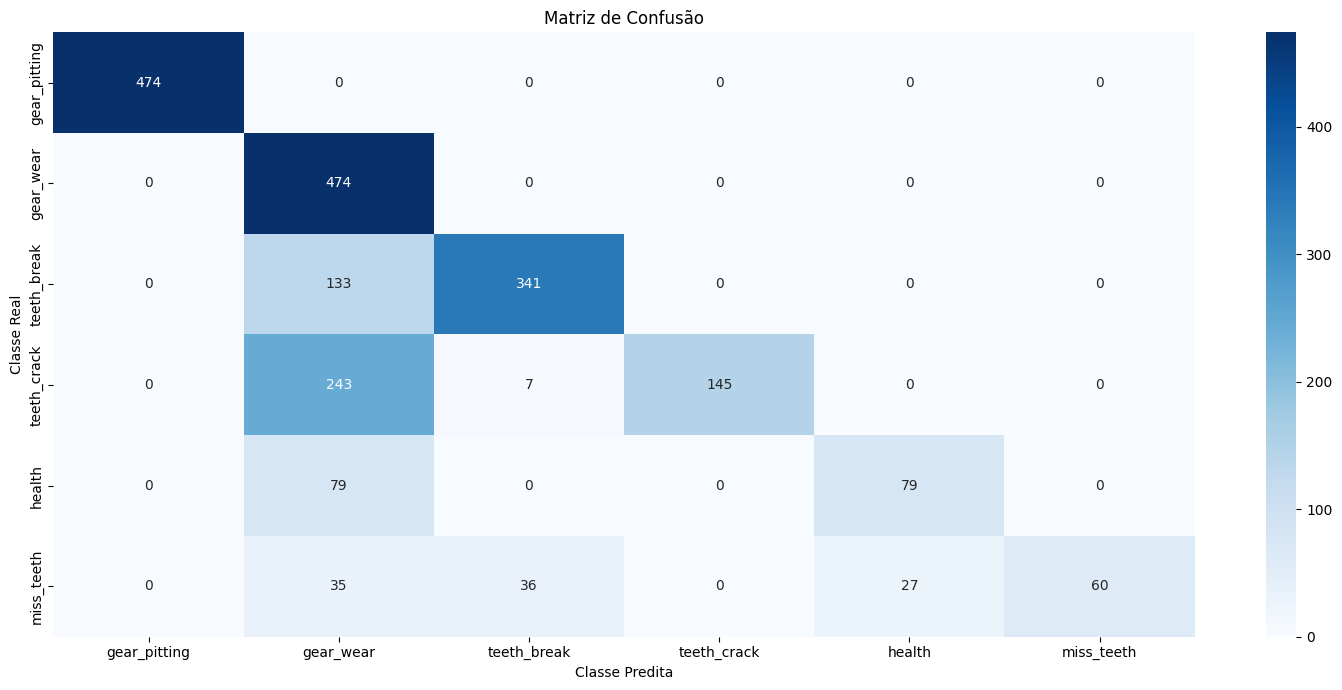

Accuracy: 73.75%
Precision: 85.42%
Recall: 66.10%
F1 Score: 69.00%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.49      1.00      0.66       474
 teeth_break       0.75      0.50      0.60       158
 teeth_crack       1.00      0.38      0.55       158
      health       0.89      0.72      0.79       474
  miss_teeth       1.00      0.37      0.54       395

    accuracy                           0.74      2133
   macro avg       0.85      0.66      0.69      2133
weighted avg       0.84      0.74      0.73      2133

Probability scores not found in features_resposta DataFrame.
Valores para 9 features analisadas
Iteration 9: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk']


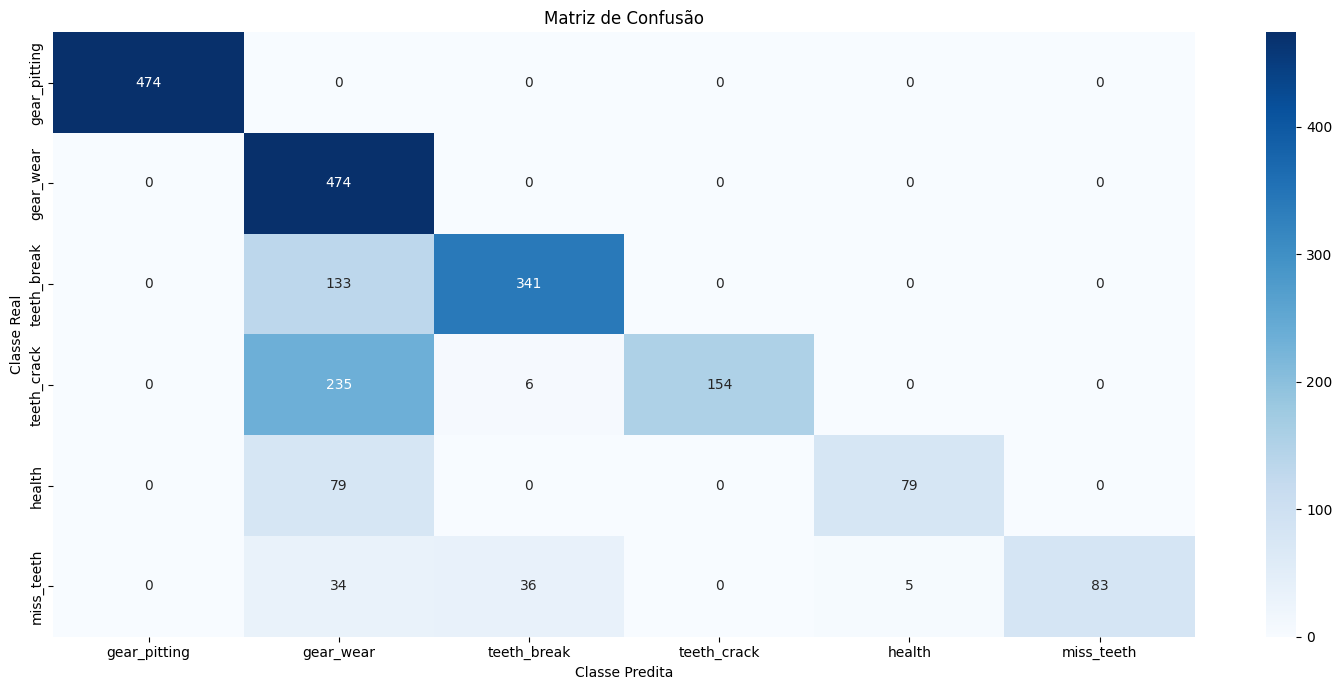

Accuracy: 75.25%
Precision: 88.79%
Recall: 68.91%
F1 Score: 72.70%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.50      1.00      0.66       474
 teeth_break       0.94      0.50      0.65       158
 teeth_crack       1.00      0.53      0.69       158
      health       0.89      0.72      0.80       474
  miss_teeth       1.00      0.39      0.56       395

    accuracy                           0.75      2133
   macro avg       0.89      0.69      0.73      2133
weighted avg       0.86      0.75      0.75      2133

Probability scores not found in features_resposta DataFrame.
Valores para 10 features analisadas
Iteration 10: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

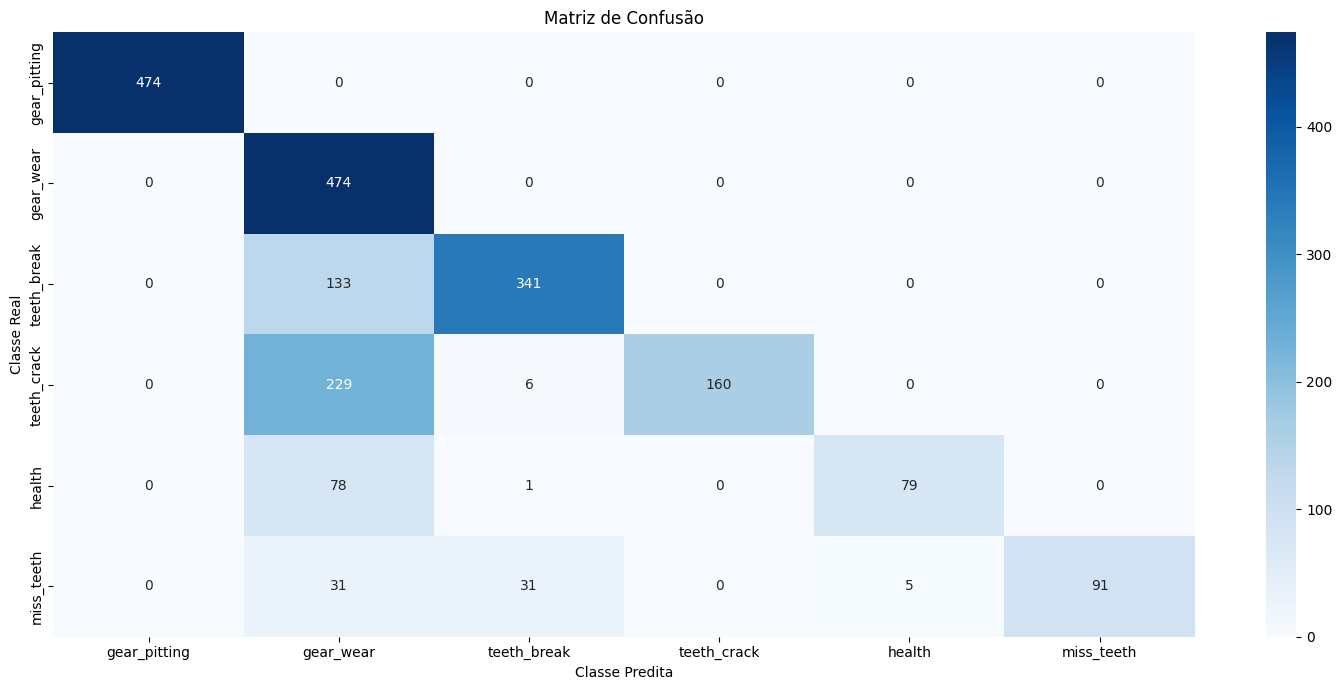

Accuracy: 75.90%
Precision: 89.03%
Recall: 70.01%
F1 Score: 73.80%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.50      1.00      0.67       474
 teeth_break       0.94      0.50      0.65       158
 teeth_crack       1.00      0.58      0.73       158
      health       0.90      0.72      0.80       474
  miss_teeth       1.00      0.41      0.58       395

    accuracy                           0.76      2133
   macro avg       0.89      0.70      0.74      2133
weighted avg       0.86      0.76      0.76      2133

Probability scores not found in features_resposta DataFrame.
Valores para 11 features analisadas
Iteration 11: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

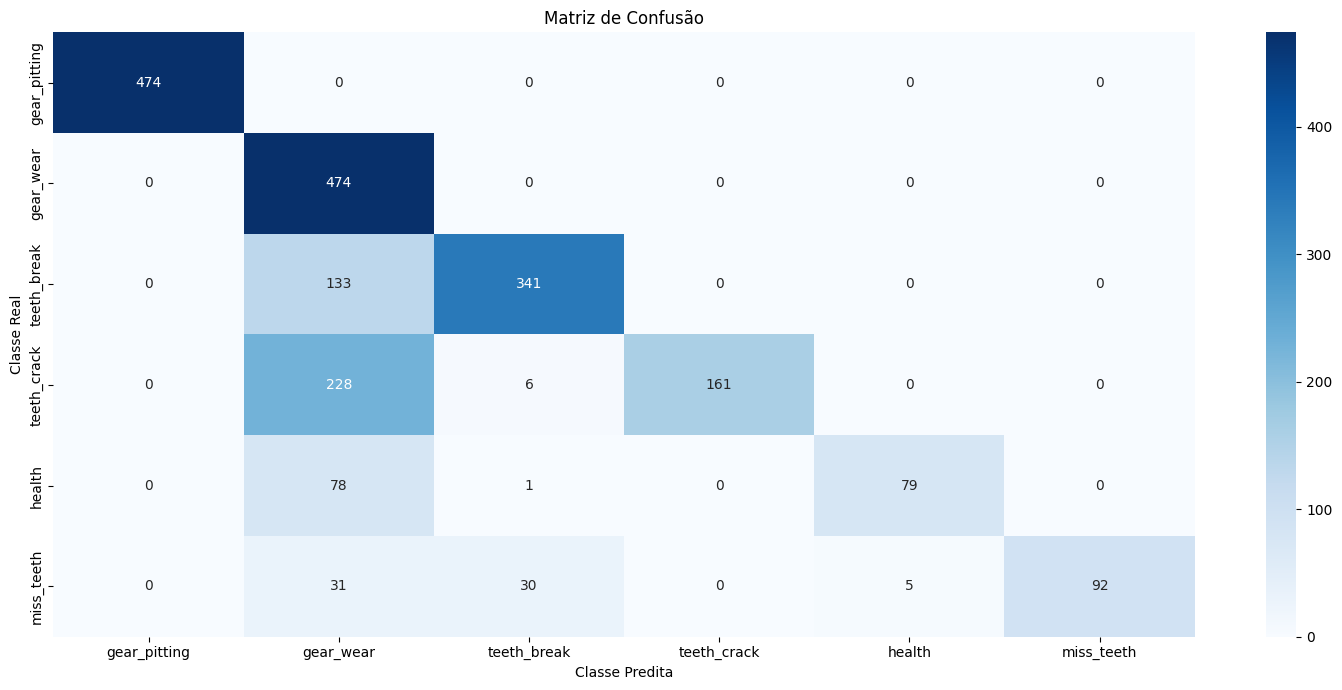

Accuracy: 76.00%
Precision: 89.08%
Recall: 70.15%
F1 Score: 73.95%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.50      1.00      0.67       474
 teeth_break       0.94      0.50      0.65       158
 teeth_crack       1.00      0.58      0.74       158
      health       0.90      0.72      0.80       474
  miss_teeth       1.00      0.41      0.58       395

    accuracy                           0.76      2133
   macro avg       0.89      0.70      0.74      2133
weighted avg       0.86      0.76      0.76      2133

Probability scores not found in features_resposta DataFrame.
Valores para 12 features analisadas
Iteration 12: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

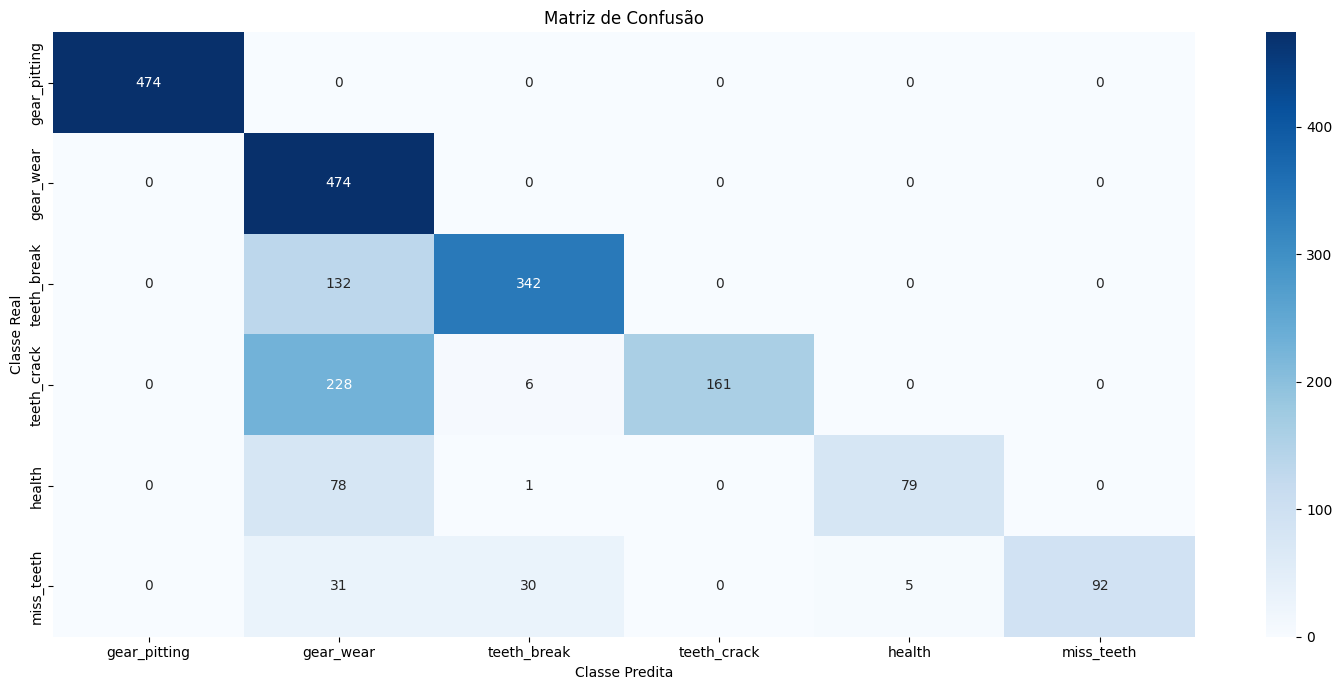

Accuracy: 76.04%
Precision: 89.09%
Recall: 70.19%
F1 Score: 73.98%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.50      1.00      0.67       474
 teeth_break       0.94      0.50      0.65       158
 teeth_crack       1.00      0.58      0.74       158
      health       0.90      0.72      0.80       474
  miss_teeth       1.00      0.41      0.58       395

    accuracy                           0.76      2133
   macro avg       0.89      0.70      0.74      2133
weighted avg       0.86      0.76      0.76      2133

Probability scores not found in features_resposta DataFrame.
Valores para 13 features analisadas
Iteration 13: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

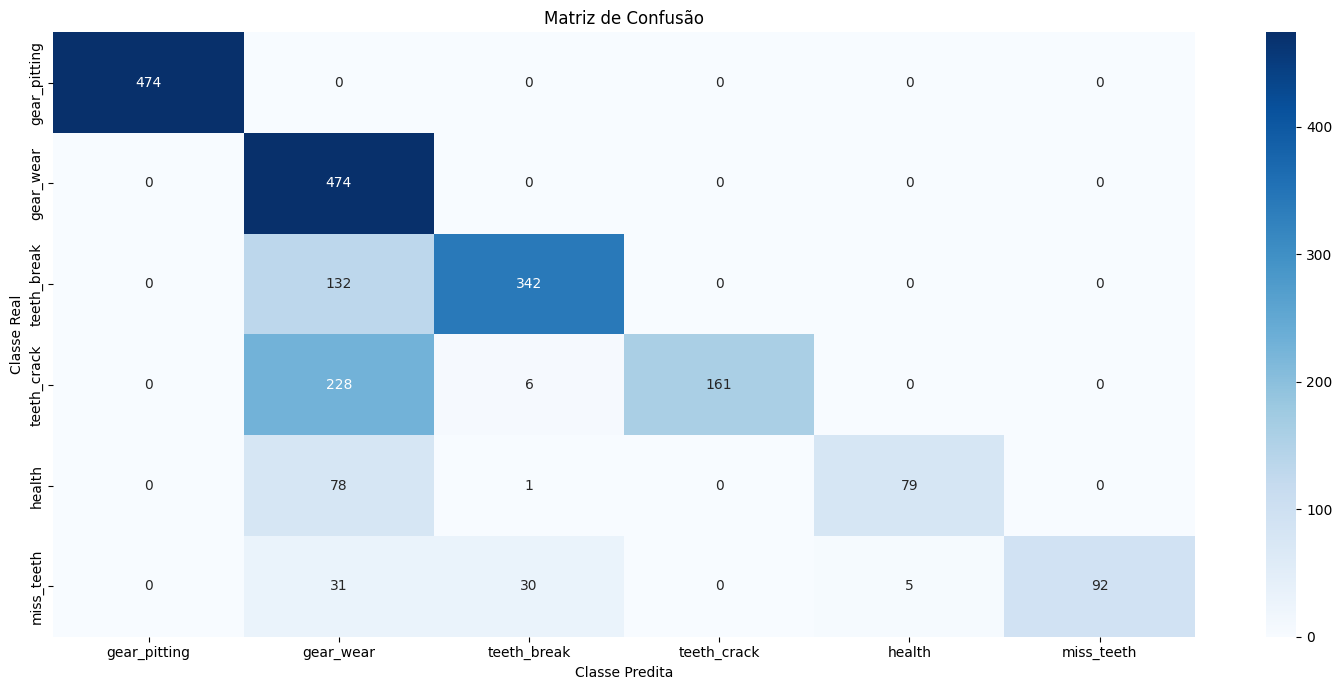

Accuracy: 76.04%
Precision: 89.09%
Recall: 70.19%
F1 Score: 73.98%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.50      1.00      0.67       474
 teeth_break       0.94      0.50      0.65       158
 teeth_crack       1.00      0.58      0.74       158
      health       0.90      0.72      0.80       474
  miss_teeth       1.00      0.41      0.58       395

    accuracy                           0.76      2133
   macro avg       0.89      0.70      0.74      2133
weighted avg       0.86      0.76      0.76      2133

Probability scores not found in features_resposta DataFrame.
Valores para 14 features analisadas
Iteration 14: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

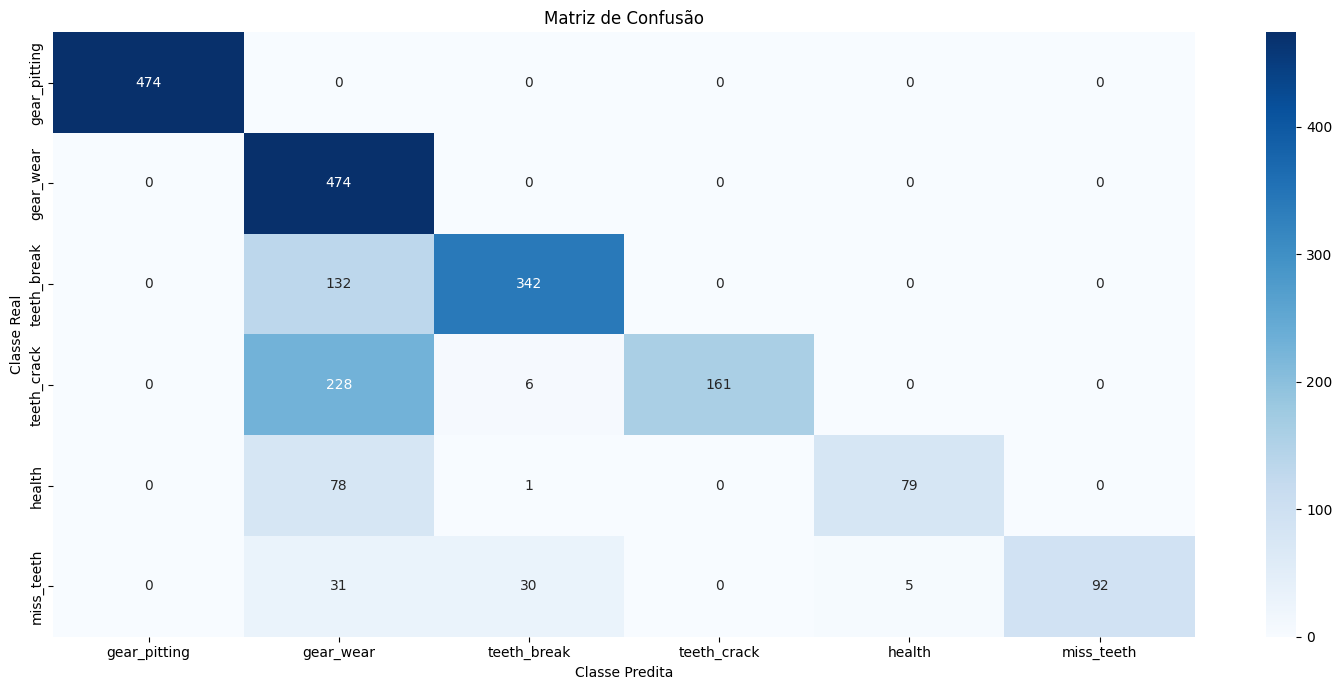

Accuracy: 76.04%
Precision: 89.09%
Recall: 70.19%
F1 Score: 73.98%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.50      1.00      0.67       474
 teeth_break       0.94      0.50      0.65       158
 teeth_crack       1.00      0.58      0.74       158
      health       0.90      0.72      0.80       474
  miss_teeth       1.00      0.41      0.58       395

    accuracy                           0.76      2133
   macro avg       0.89      0.70      0.74      2133
weighted avg       0.86      0.76      0.76      2133

Probability scores not found in features_resposta DataFrame.
Valores para 15 features analisadas
Iteration 15: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

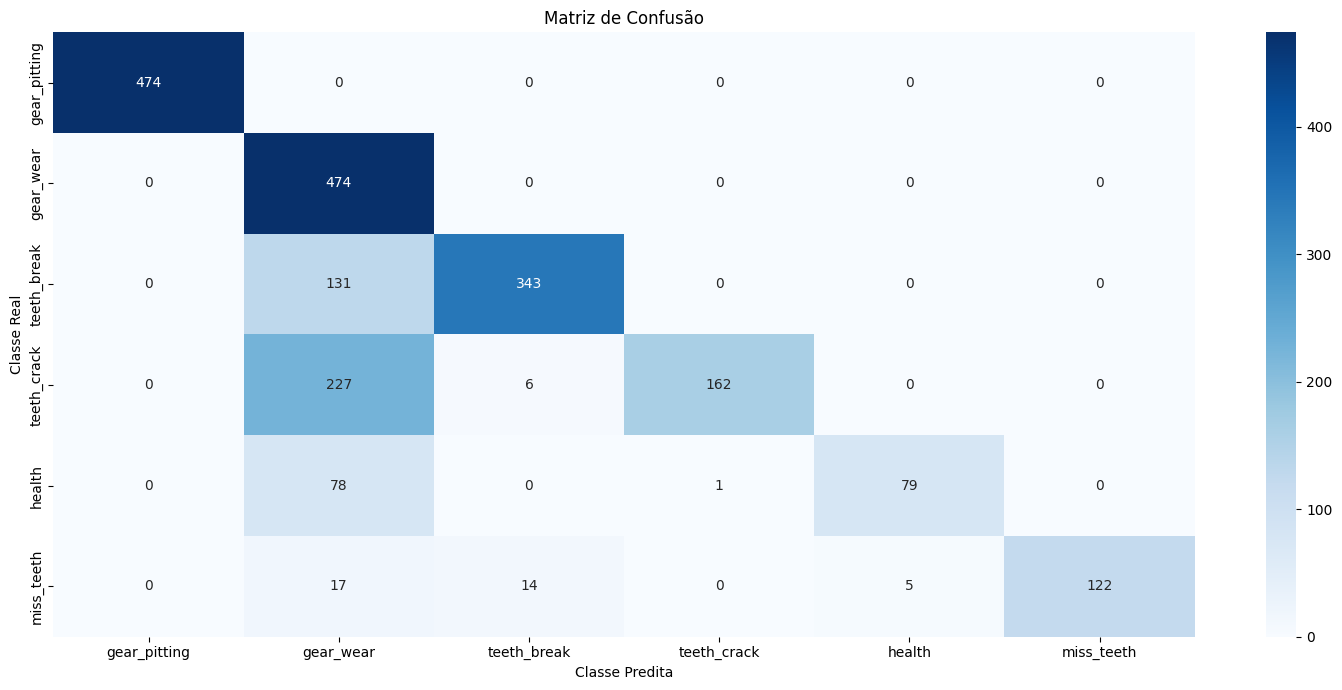

Accuracy: 77.54%
Precision: 89.84%
Recall: 73.43%
F1 Score: 76.69%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.51      1.00      0.68       474
 teeth_break       0.94      0.50      0.65       158
 teeth_crack       1.00      0.77      0.87       158
      health       0.94      0.72      0.82       474
  miss_teeth       0.99      0.41      0.58       395

    accuracy                           0.78      2133
   macro avg       0.90      0.73      0.77      2133
weighted avg       0.87      0.78      0.78      2133

Probability scores not found in features_resposta DataFrame.
Valores para 16 features analisadas
Iteration 16: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

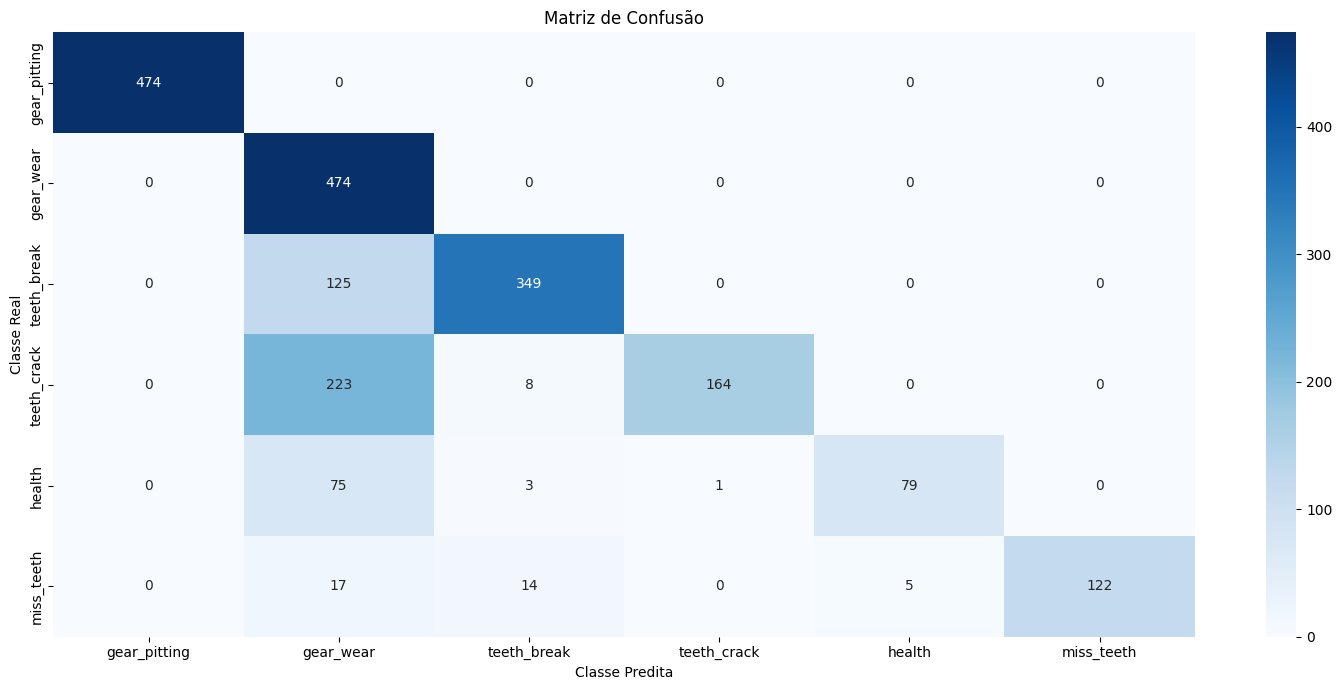

Accuracy: 77.92%
Precision: 89.77%
Recall: 73.73%
F1 Score: 76.94%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.52      1.00      0.68       474
 teeth_break       0.94      0.50      0.65       158
 teeth_crack       1.00      0.77      0.87       158
      health       0.93      0.74      0.82       474
  miss_teeth       0.99      0.42      0.59       395

    accuracy                           0.78      2133
   macro avg       0.90      0.74      0.77      2133
weighted avg       0.87      0.78      0.78      2133

Probability scores not found in features_resposta DataFrame.
Valores para 17 features analisadas
Iteration 17: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

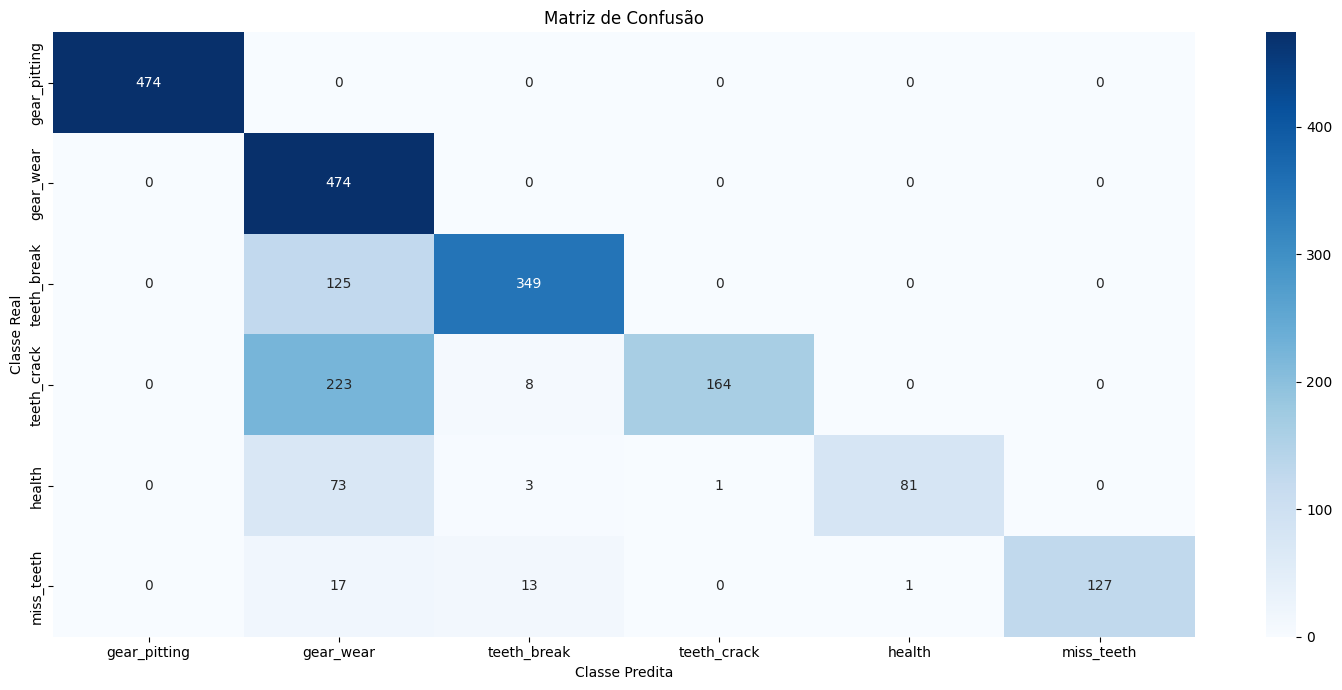

Accuracy: 78.25%
Precision: 90.62%
Recall: 74.47%
F1 Score: 77.67%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.52      1.00      0.68       474
 teeth_break       0.99      0.51      0.67       158
 teeth_crack       1.00      0.80      0.89       158
      health       0.94      0.74      0.82       474
  miss_teeth       0.99      0.42      0.59       395

    accuracy                           0.78      2133
   macro avg       0.91      0.74      0.78      2133
weighted avg       0.88      0.78      0.78      2133

Probability scores not found in features_resposta DataFrame.
Valores para 18 features analisadas
Iteration 18: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

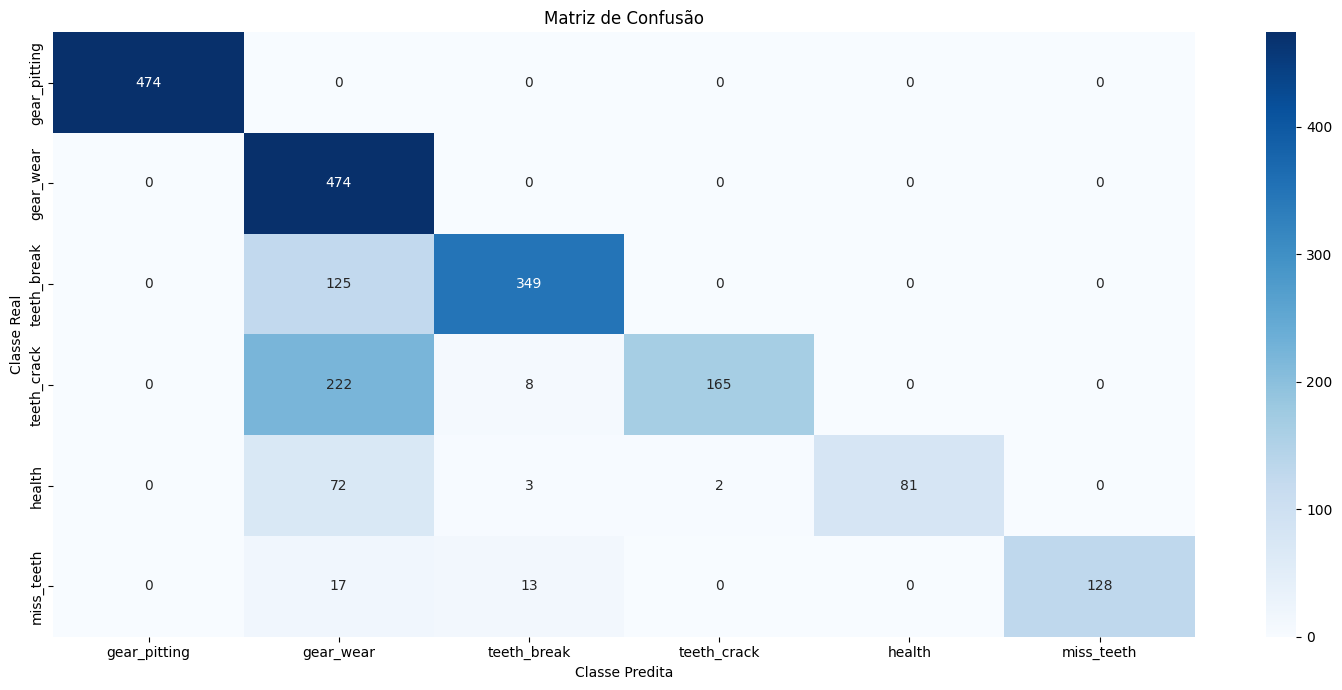

Accuracy: 78.34%
Precision: 90.74%
Recall: 74.61%
F1 Score: 77.82%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.52      1.00      0.68       474
 teeth_break       1.00      0.51      0.68       158
 teeth_crack       1.00      0.81      0.90       158
      health       0.94      0.74      0.82       474
  miss_teeth       0.99      0.42      0.59       395

    accuracy                           0.78      2133
   macro avg       0.91      0.75      0.78      2133
weighted avg       0.88      0.78      0.78      2133

Probability scores not found in features_resposta DataFrame.
Valores para 19 features analisadas
Iteration 19: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

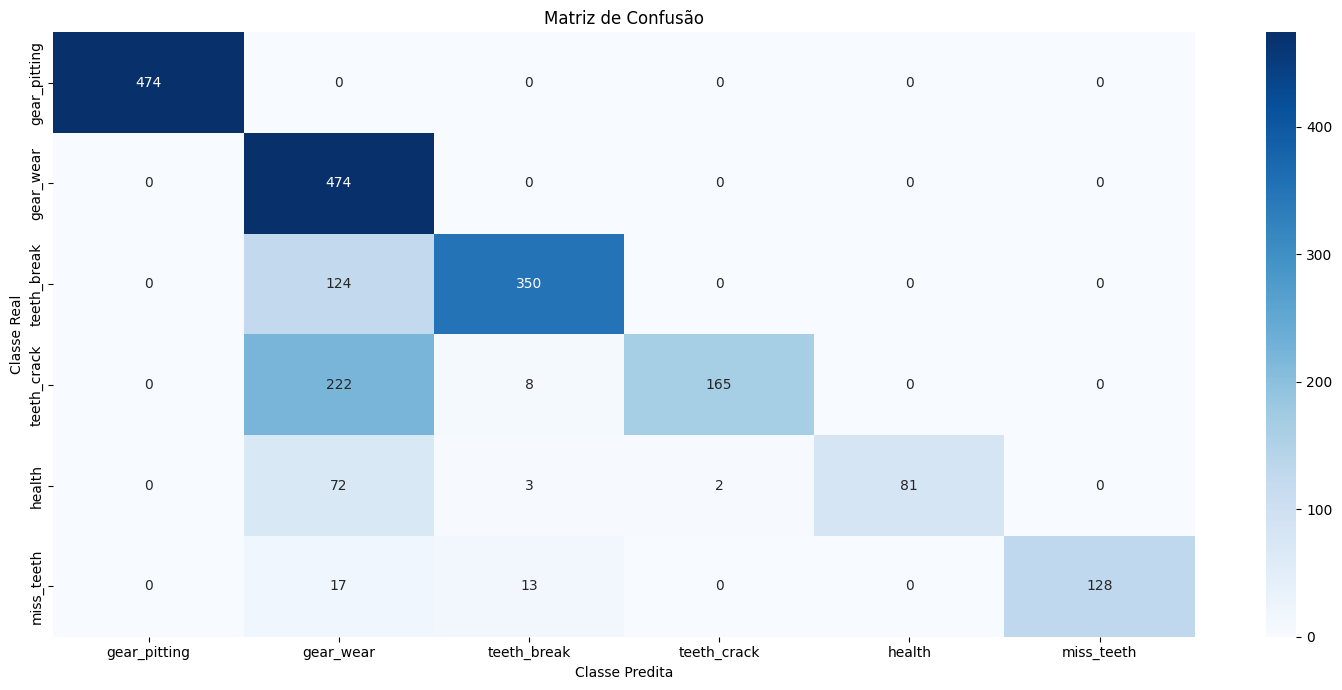

Accuracy: 78.39%
Precision: 90.76%
Recall: 74.65%
F1 Score: 77.85%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.52      1.00      0.69       474
 teeth_break       1.00      0.51      0.68       158
 teeth_crack       1.00      0.81      0.90       158
      health       0.94      0.74      0.83       474
  miss_teeth       0.99      0.42      0.59       395

    accuracy                           0.78      2133
   macro avg       0.91      0.75      0.78      2133
weighted avg       0.88      0.78      0.78      2133

Probability scores not found in features_resposta DataFrame.
Valores para 20 features analisadas
Iteration 20: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

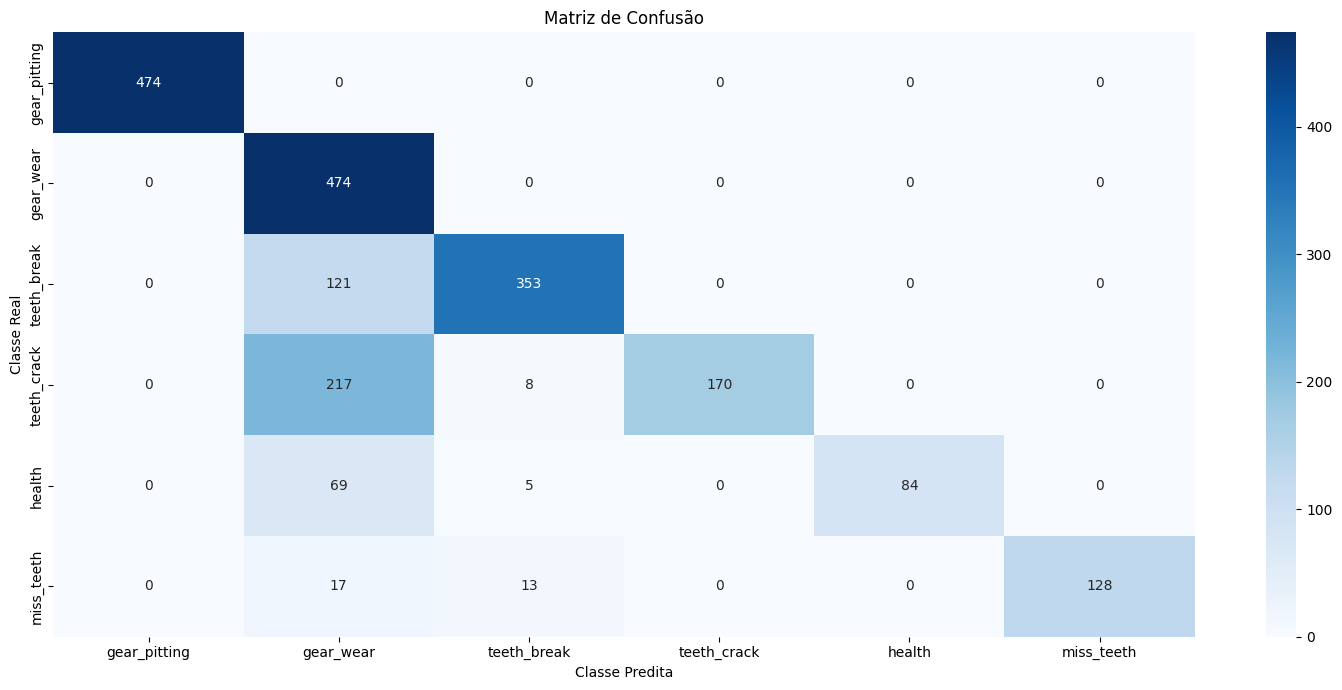

Accuracy: 78.90%
Precision: 90.99%
Recall: 75.28%
F1 Score: 78.50%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.53      1.00      0.69       474
 teeth_break       1.00      0.53      0.69       158
 teeth_crack       1.00      0.81      0.90       158
      health       0.93      0.74      0.83       474
  miss_teeth       1.00      0.43      0.60       395

    accuracy                           0.79      2133
   macro avg       0.91      0.75      0.78      2133
weighted avg       0.88      0.79      0.79      2133

Probability scores not found in features_resposta DataFrame.
Valores para 21 features analisadas
Iteration 21: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

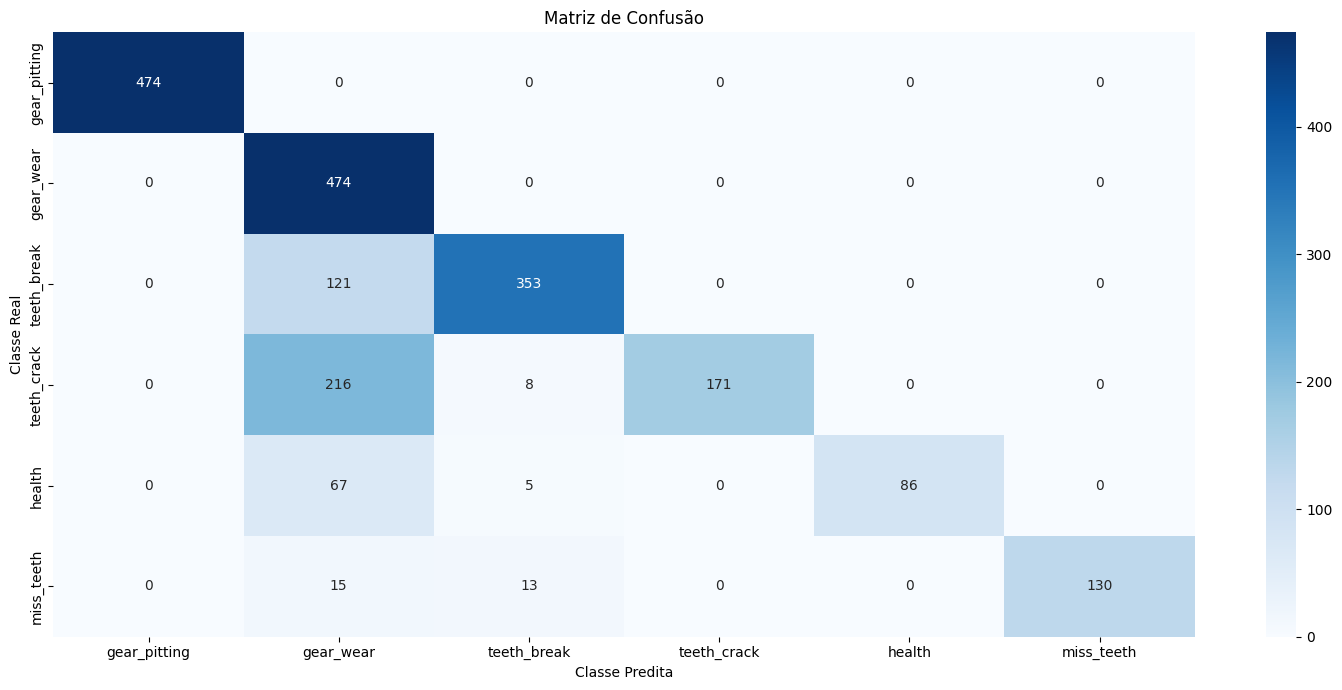

Accuracy: 79.14%
Precision: 91.04%
Recall: 75.75%
F1 Score: 78.88%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.53      1.00      0.69       474
 teeth_break       1.00      0.54      0.70       158
 teeth_crack       1.00      0.82      0.90       158
      health       0.93      0.74      0.83       474
  miss_teeth       1.00      0.43      0.60       395

    accuracy                           0.79      2133
   macro avg       0.91      0.76      0.79      2133
weighted avg       0.88      0.79      0.79      2133

Probability scores not found in features_resposta DataFrame.
Valores para 22 features analisadas
Iteration 22: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

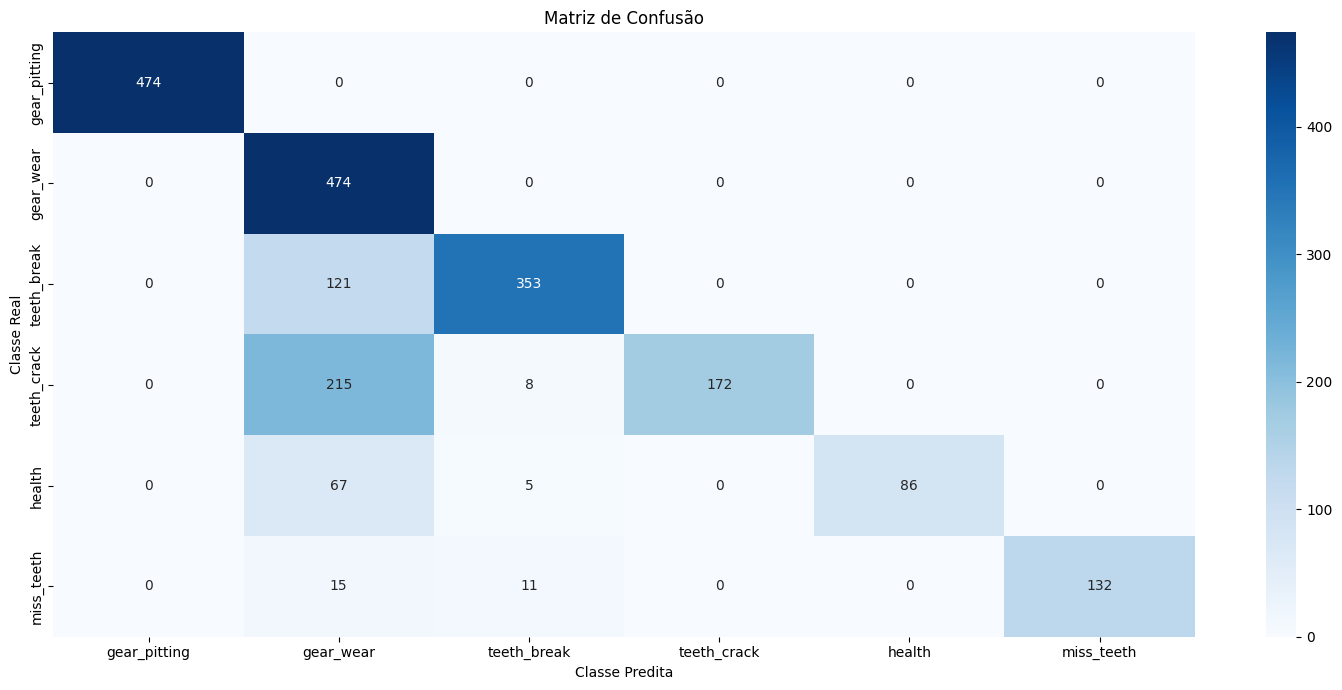

Accuracy: 79.28%
Precision: 91.13%
Recall: 76.00%
F1 Score: 79.09%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.53      1.00      0.69       474
 teeth_break       1.00      0.54      0.70       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.74      0.83       474
  miss_teeth       1.00      0.44      0.61       395

    accuracy                           0.79      2133
   macro avg       0.91      0.76      0.79      2133
weighted avg       0.88      0.79      0.79      2133

Probability scores not found in features_resposta DataFrame.
Valores para 23 features analisadas
Iteration 23: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

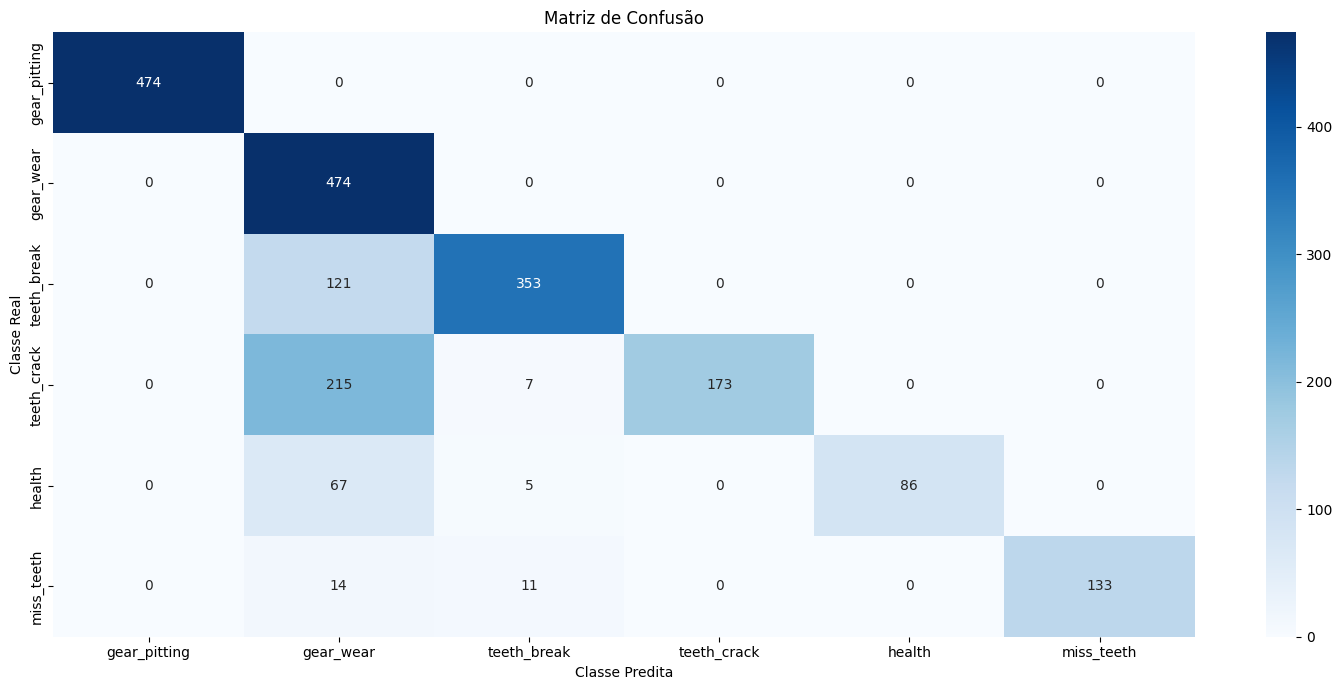

Accuracy: 79.37%
Precision: 91.18%
Recall: 76.15%
F1 Score: 79.22%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.53      1.00      0.69       474
 teeth_break       1.00      0.54      0.70       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.74      0.83       474
  miss_teeth       1.00      0.44      0.61       395

    accuracy                           0.79      2133
   macro avg       0.91      0.76      0.79      2133
weighted avg       0.88      0.79      0.79      2133

Probability scores not found in features_resposta DataFrame.
Valores para 24 features analisadas
Iteration 24: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

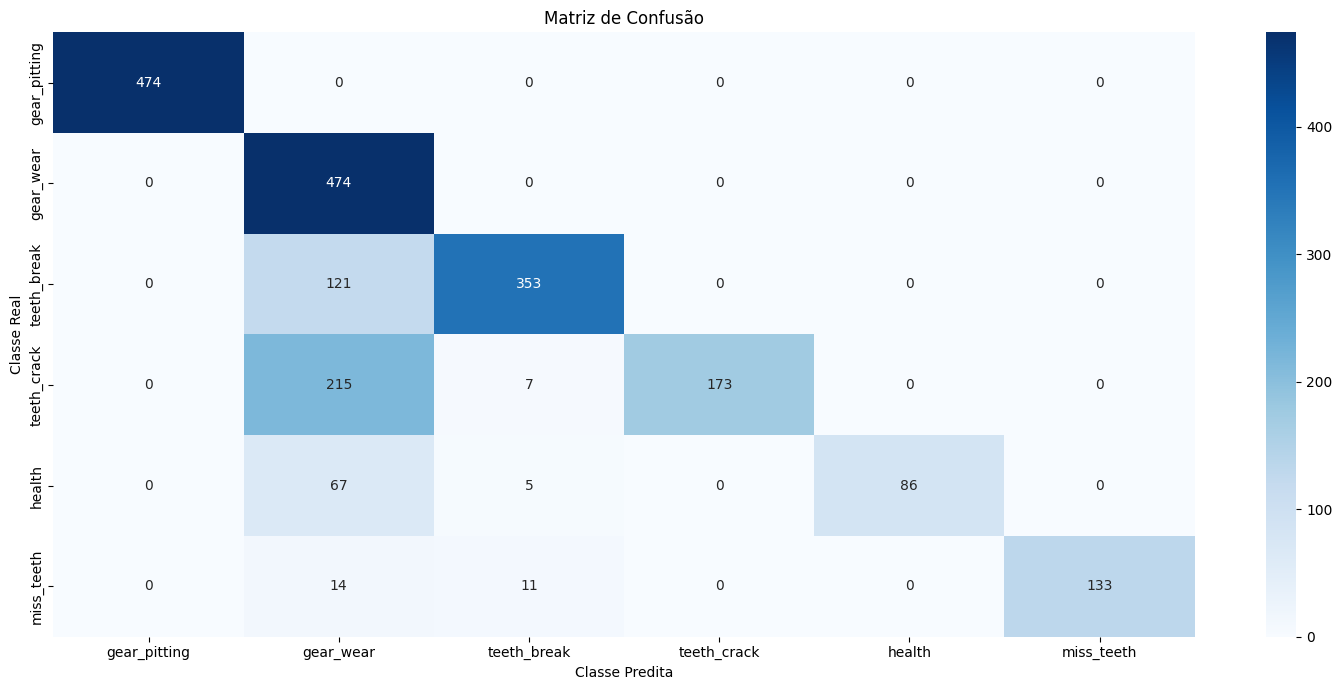

Accuracy: 79.37%
Precision: 91.18%
Recall: 76.15%
F1 Score: 79.22%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.53      1.00      0.69       474
 teeth_break       1.00      0.54      0.70       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.74      0.83       474
  miss_teeth       1.00      0.44      0.61       395

    accuracy                           0.79      2133
   macro avg       0.91      0.76      0.79      2133
weighted avg       0.88      0.79      0.79      2133

Probability scores not found in features_resposta DataFrame.
Valores para 25 features analisadas
Iteration 25: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

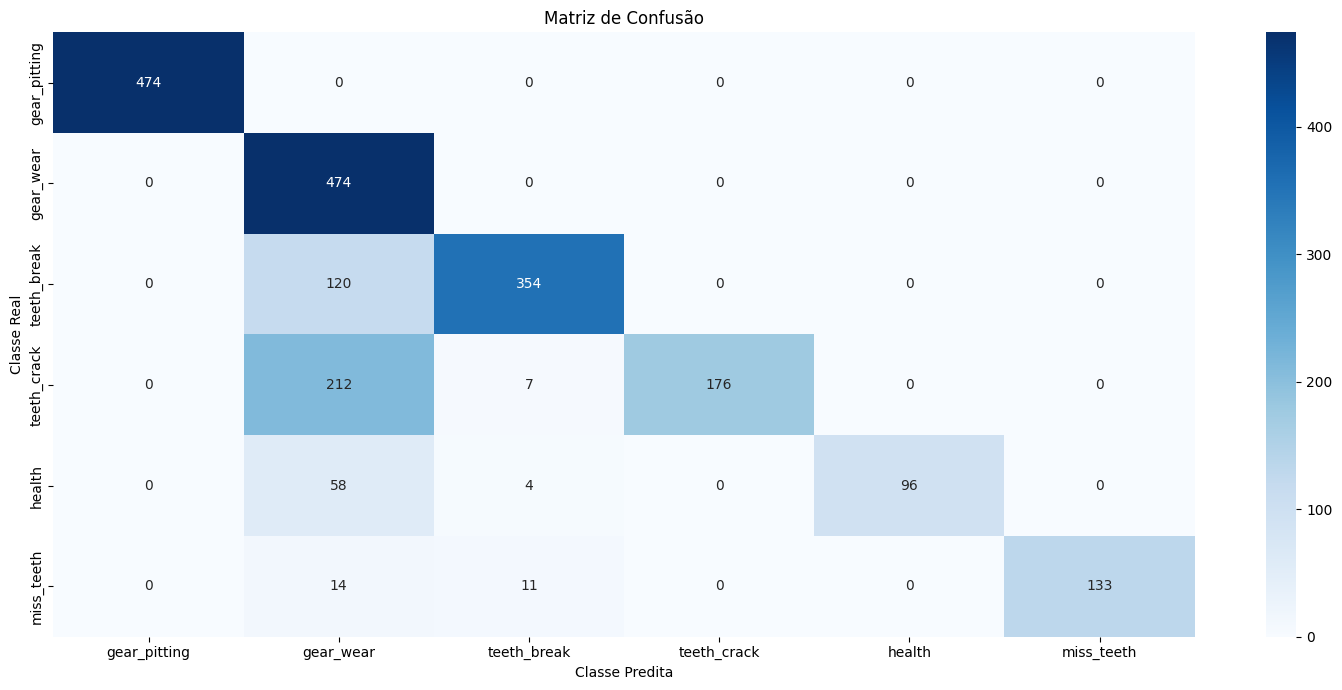

Accuracy: 80.03%
Precision: 91.36%
Recall: 77.36%
F1 Score: 80.34%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.70       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.75      0.83       474
  miss_teeth       1.00      0.45      0.62       395

    accuracy                           0.80      2133
   macro avg       0.91      0.77      0.80      2133
weighted avg       0.88      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 26 features analisadas
Iteration 26: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

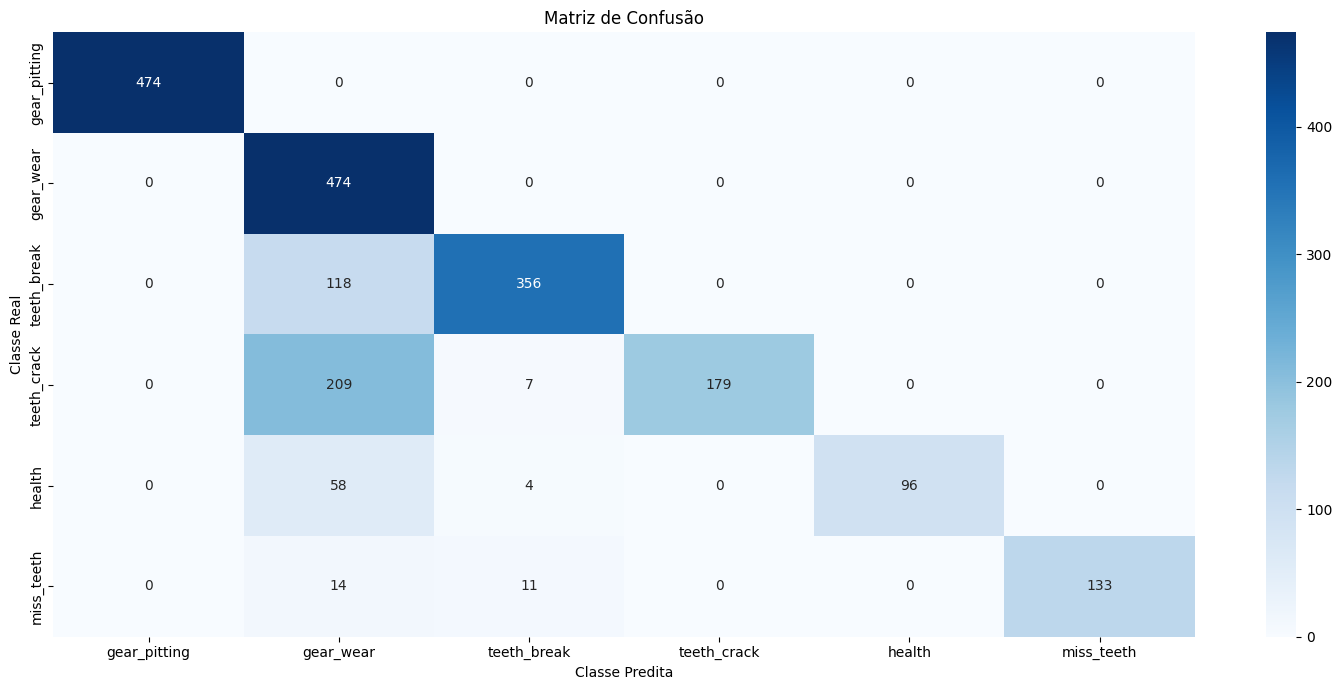

Accuracy: 80.26%
Precision: 91.41%
Recall: 77.56%
F1 Score: 80.55%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.70       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.75      0.84       474
  miss_teeth       1.00      0.45      0.62       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 27 features analisadas
Iteration 27: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

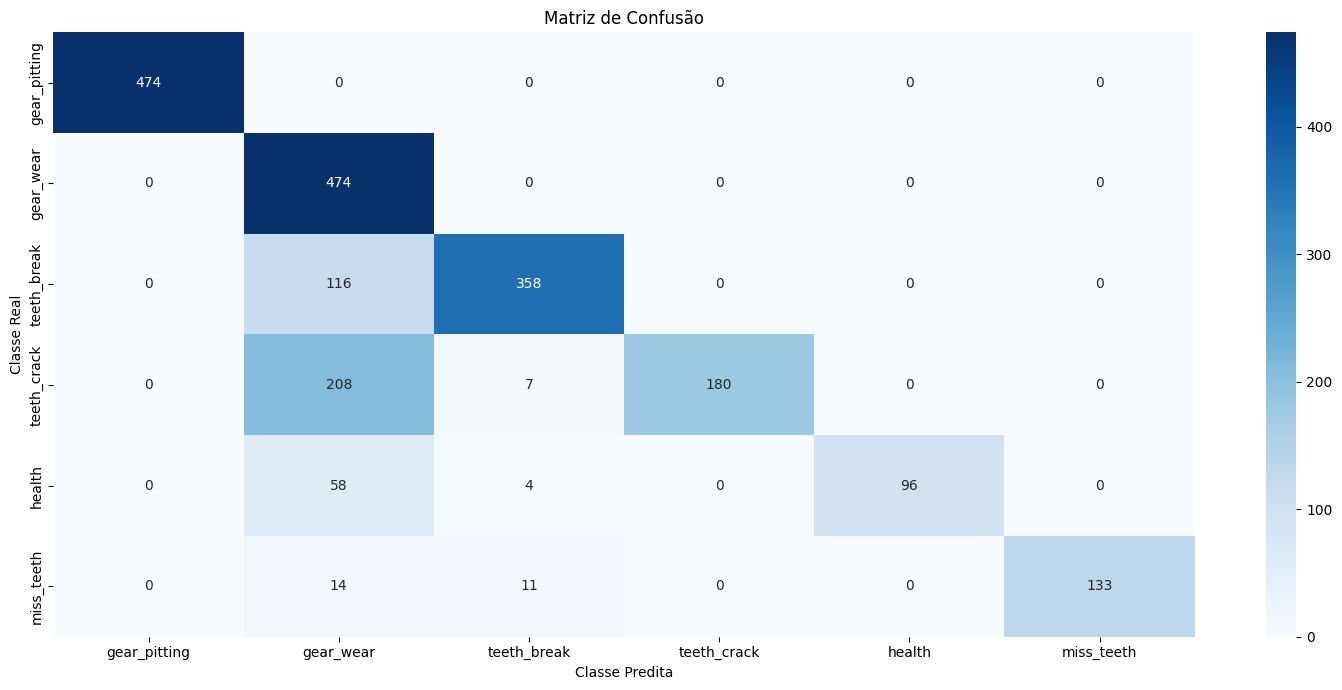

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 28: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

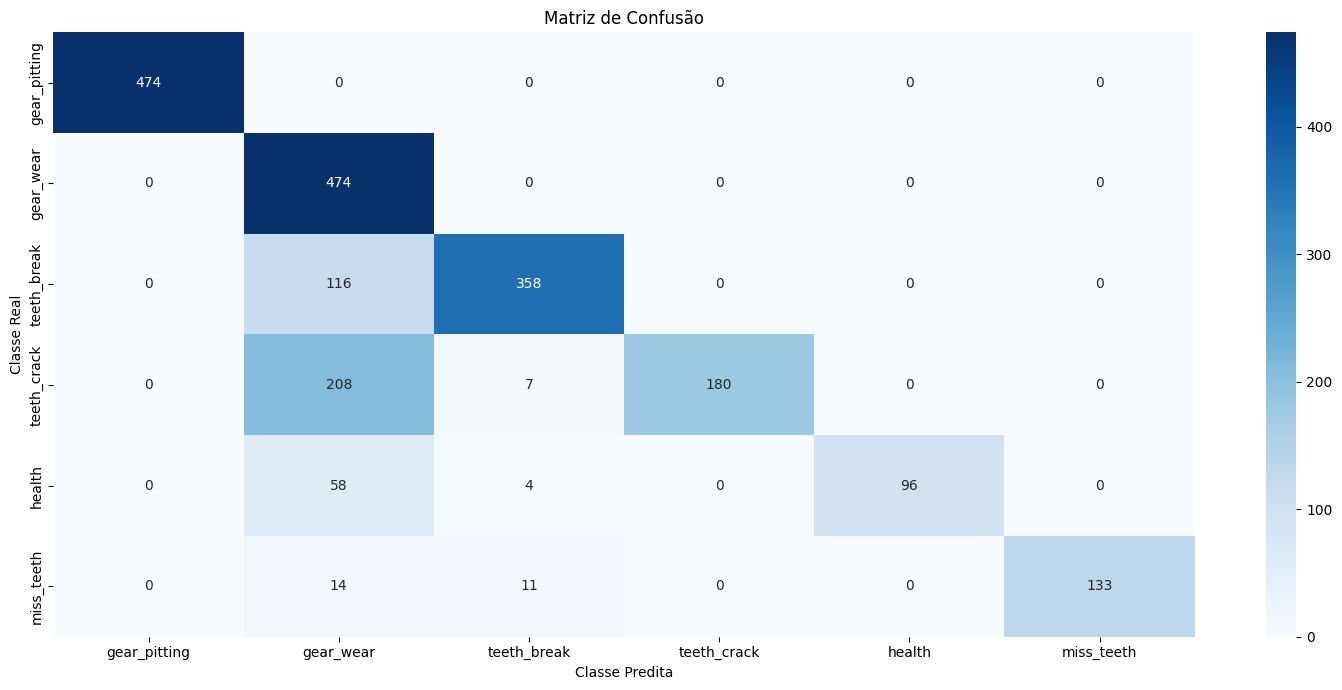

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 29: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

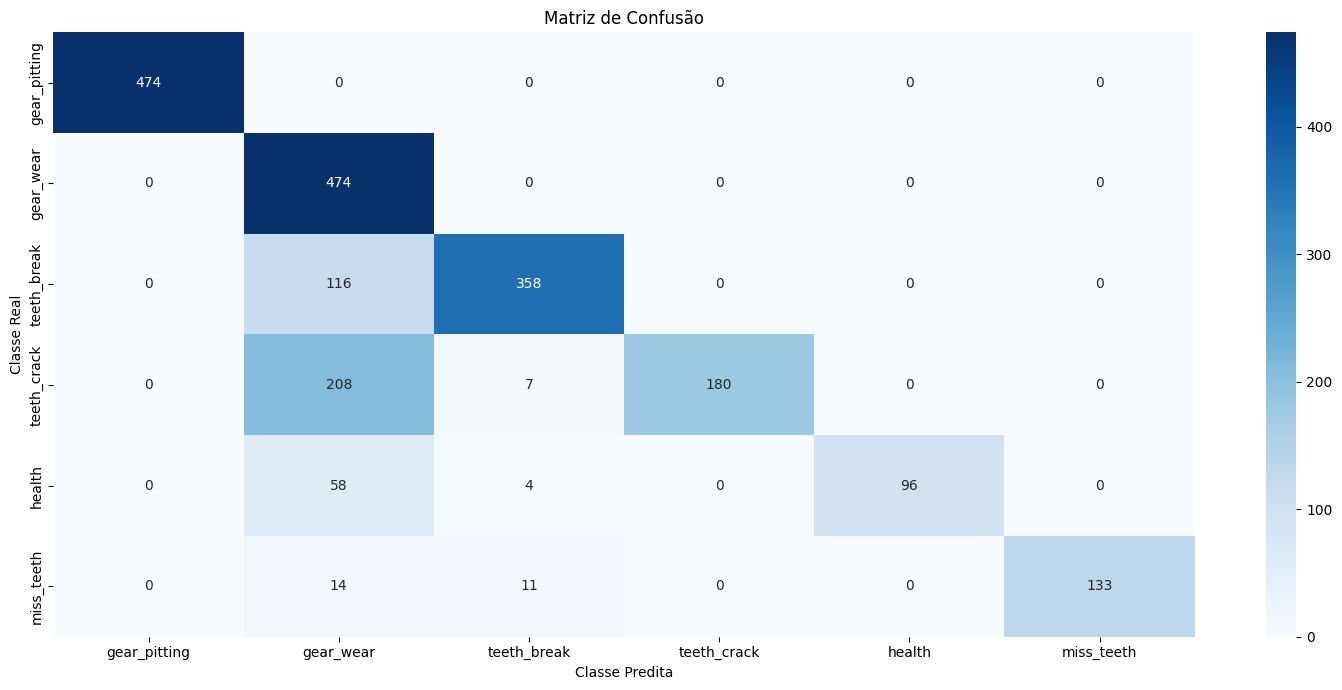

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 30: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

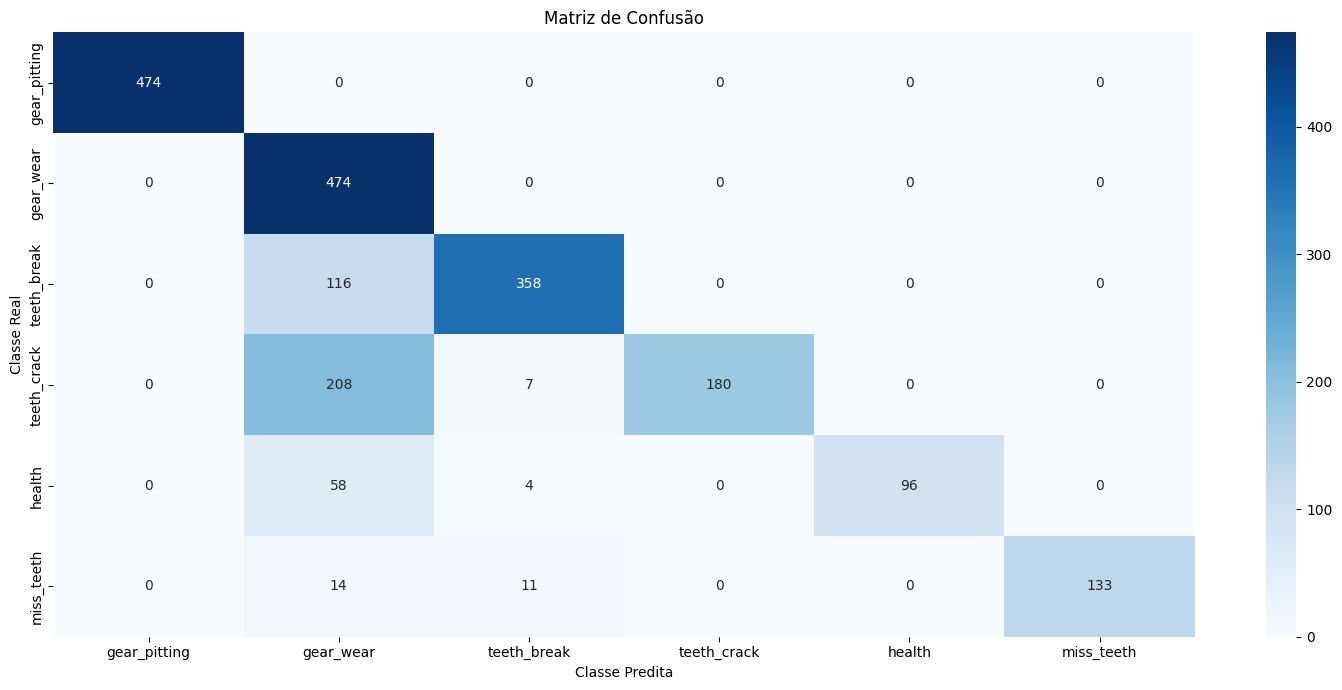

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 31: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

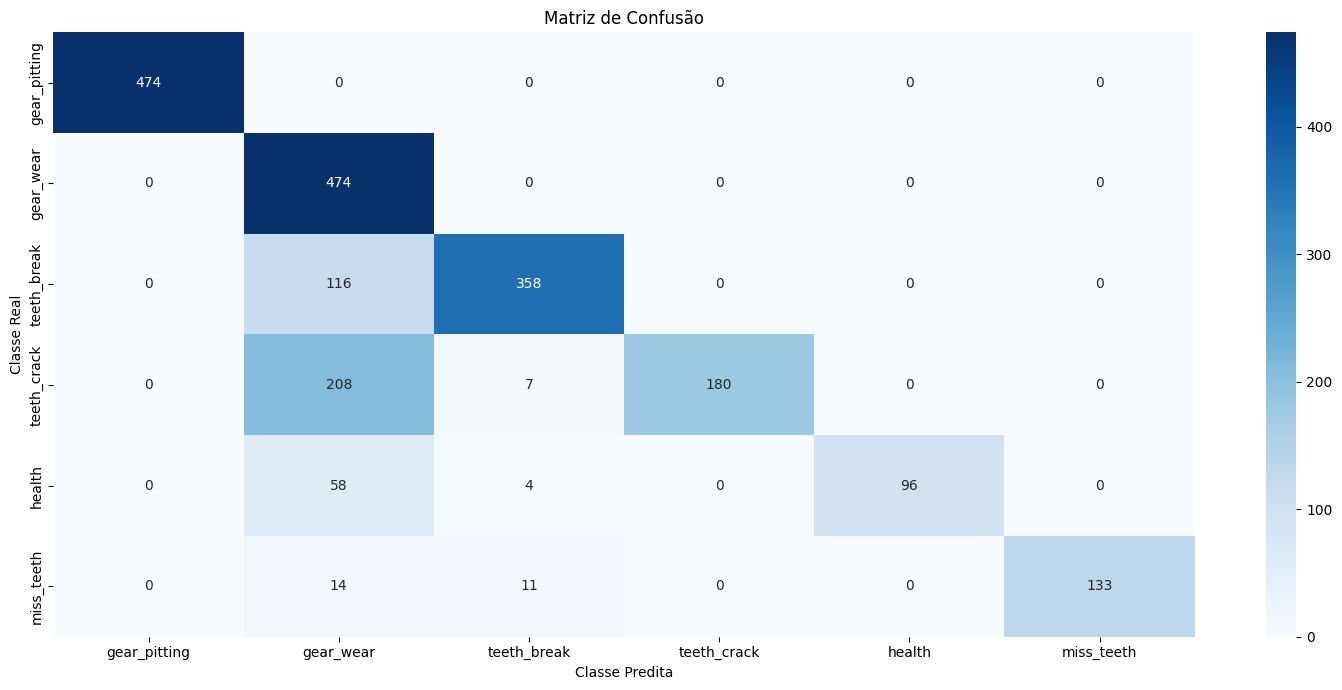

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 32: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

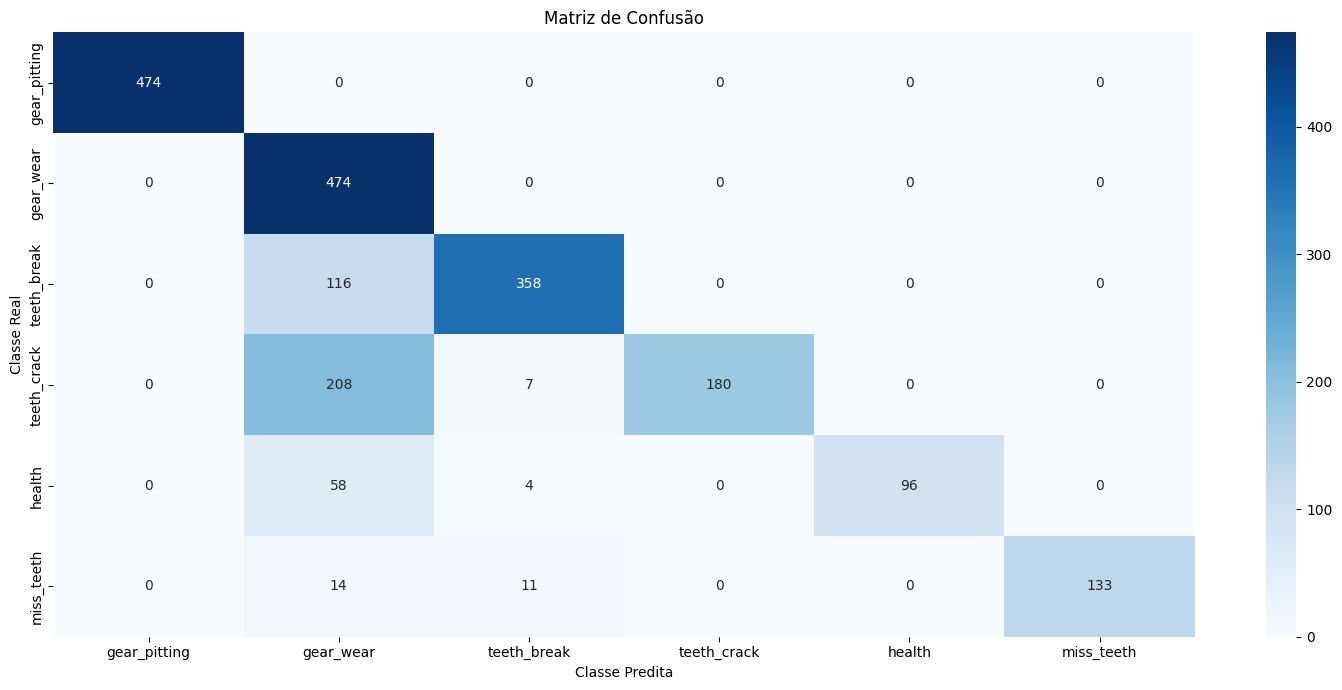

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 33: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

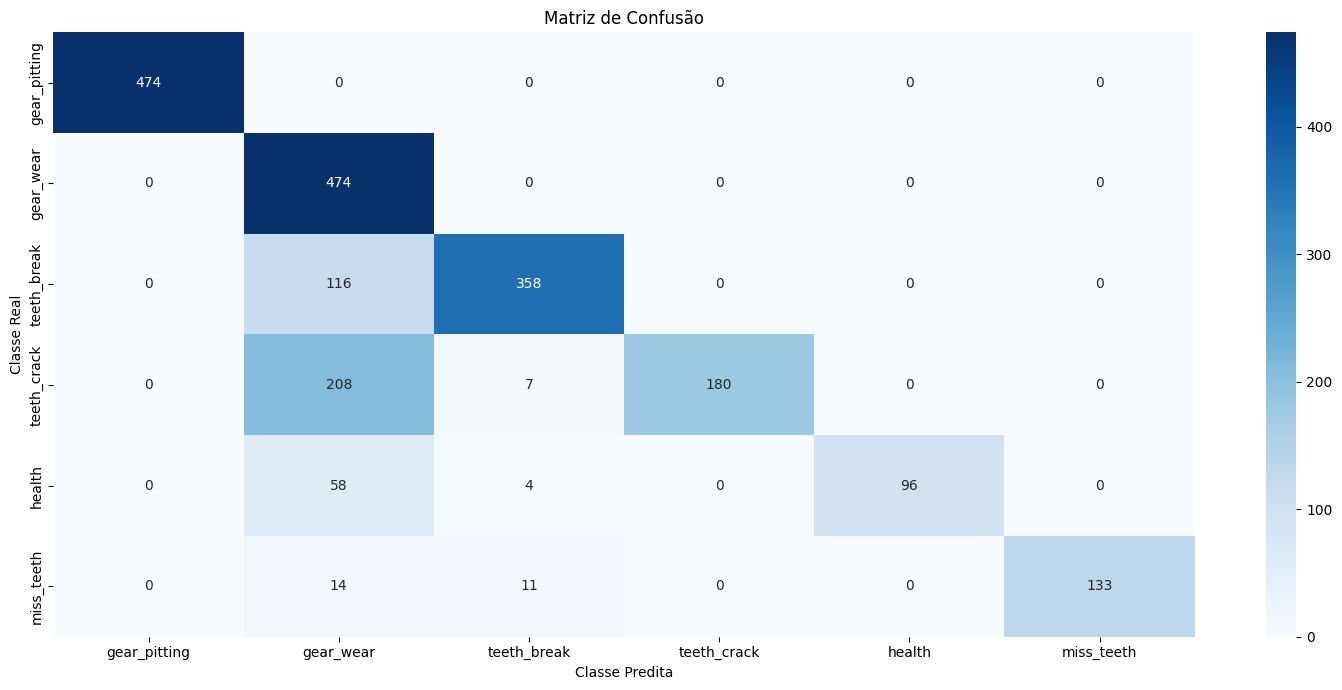

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 34: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

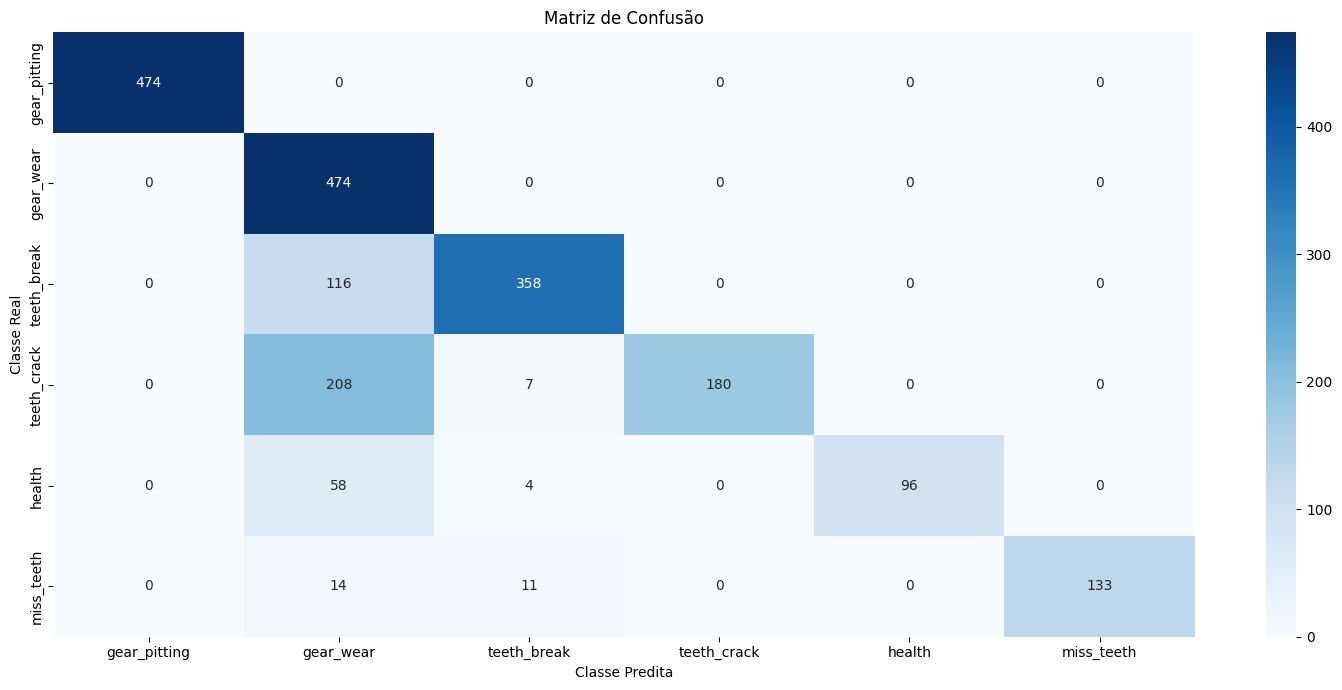

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 35: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

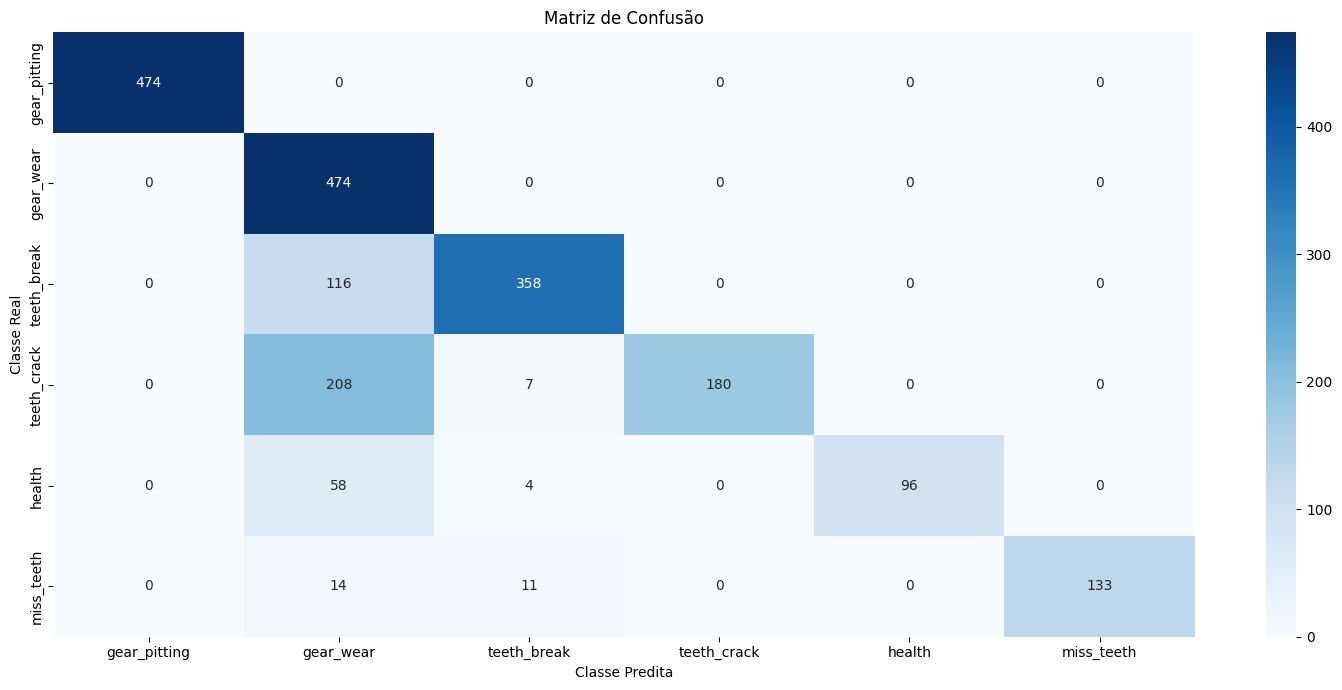

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 36: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

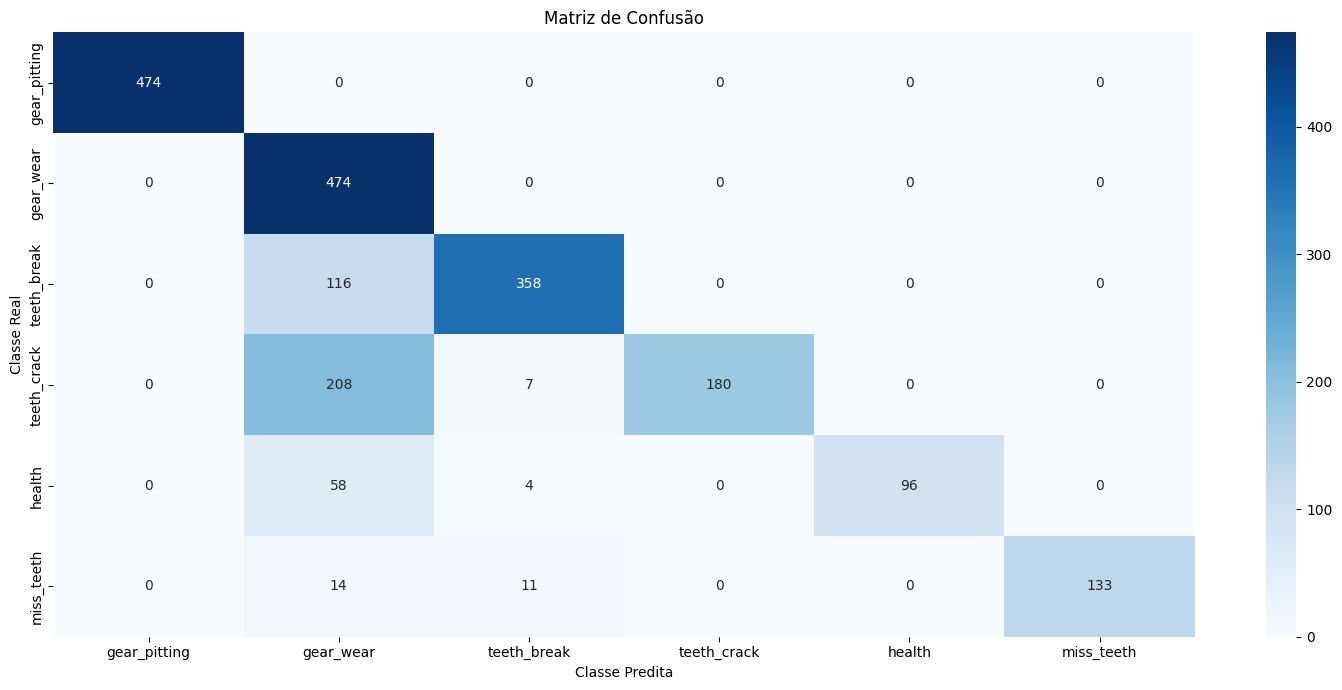

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 37: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

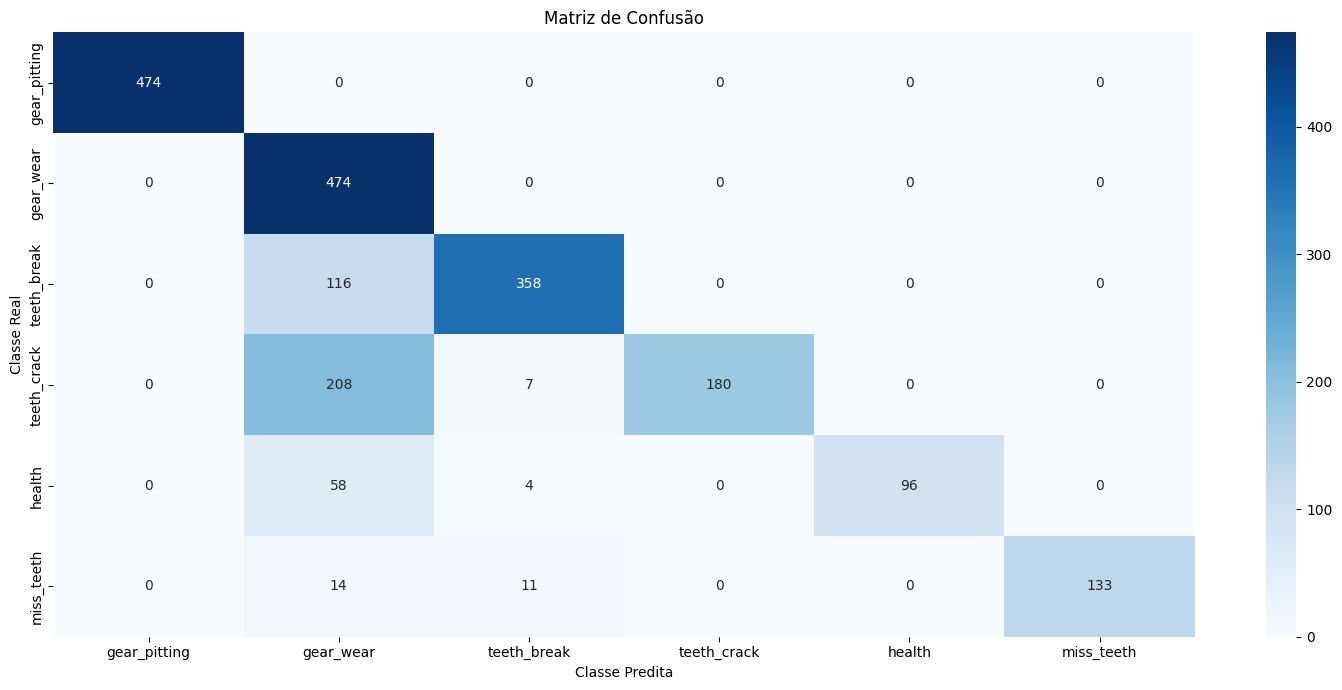

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 38: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

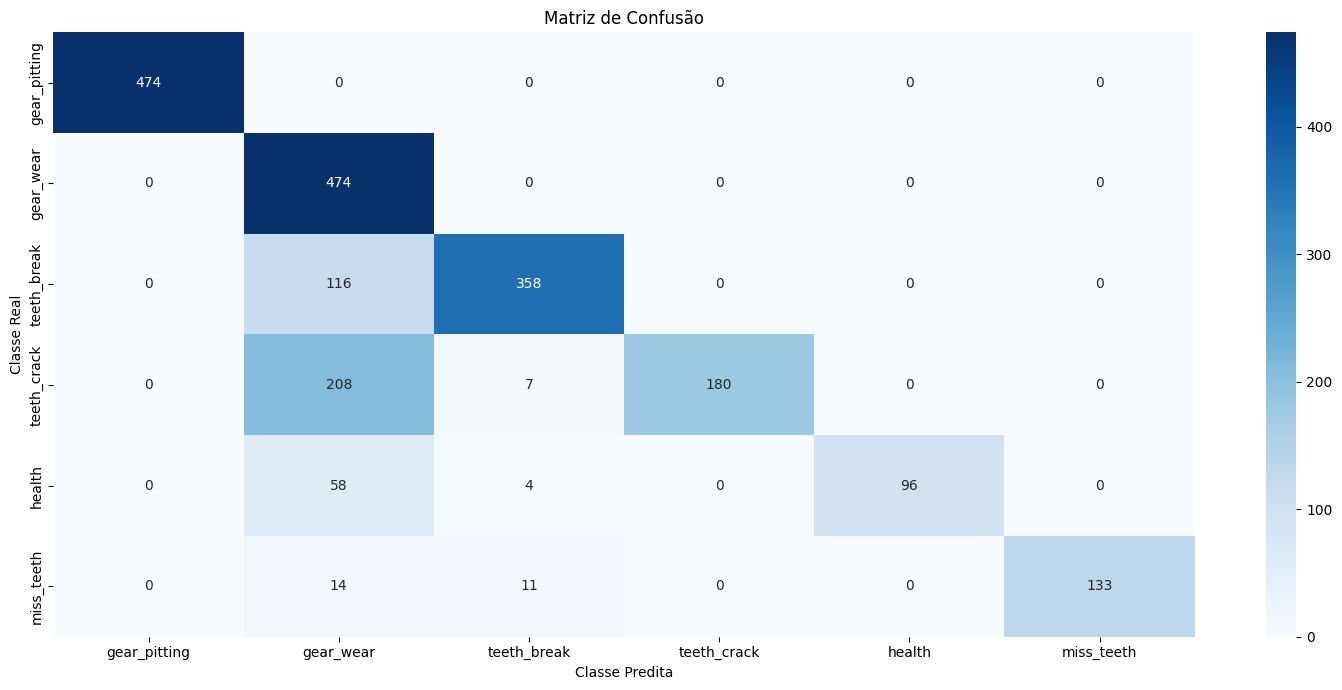

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas
Iteration 39: Selected top features: ['Input Torque.mean', 'Input Torque.rms', 'gearbox_vibration_z.rms', 'gearbox_vibration_y.rms', 'gearbox_vibration_x.skewness', 'gearbox_vibration_x.rms', 'gearbox_vibration_y.skewness', 'gearbox_vibration_z.skewness', 'gearbox_vibration_y.pk_pk', 'gearbox

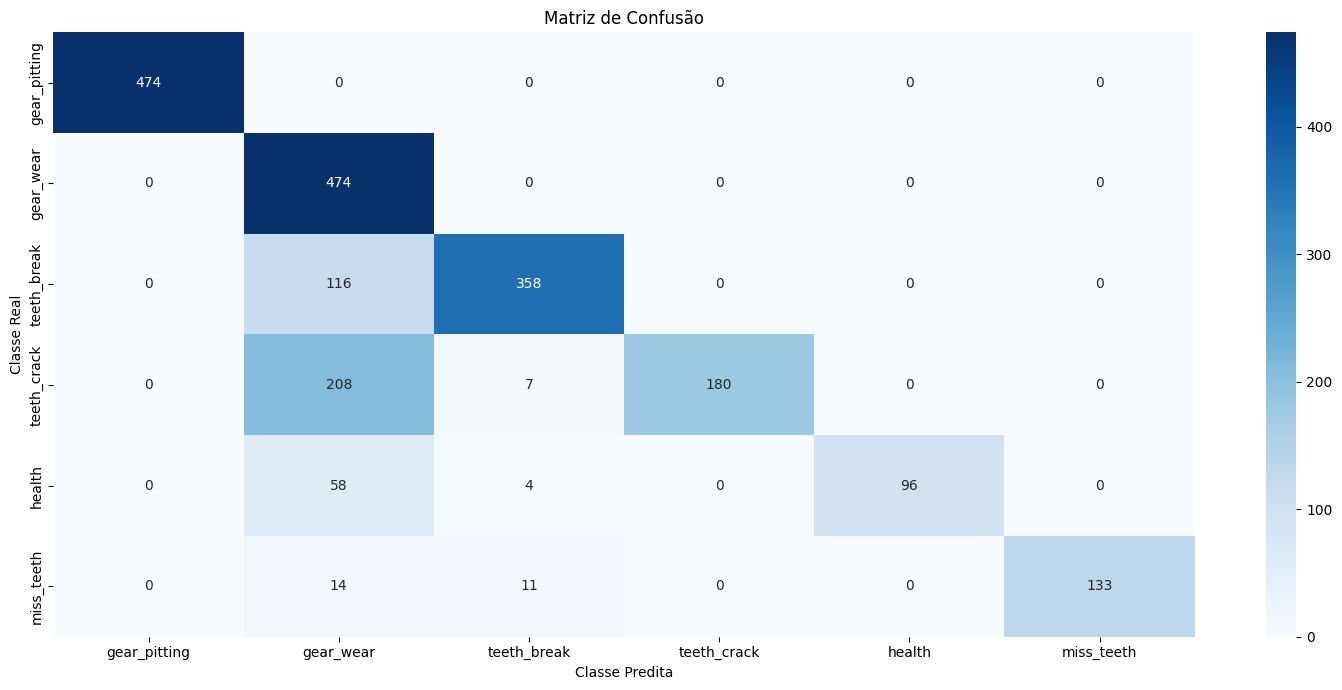

Accuracy: 80.40%
Precision: 91.45%
Recall: 77.67%
F1 Score: 80.66%
              precision    recall  f1-score   support

gear_pitting       1.00      1.00      1.00       474
   gear_wear       0.54      1.00      0.71       474
 teeth_break       1.00      0.61      0.76       158
 teeth_crack       1.00      0.84      0.91       158
      health       0.94      0.76      0.84       474
  miss_teeth       1.00      0.46      0.63       395

    accuracy                           0.80      2133
   macro avg       0.91      0.78      0.81      2133
weighted avg       0.89      0.80      0.80      2133

Probability scores not found in features_resposta DataFrame.
Valores para 28 features analisadas


In [35]:
for n in range(0,40):
    evaluate_model(gerar_features_resposta_teste(n)) 